In [ ]:
import nltk
import string
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt') #ponctuation '(),[].:?'
nltk.download('stopwords') #mots peu pertinents comme "a" "an"
nltk.download('punkt_tab')

import torch
from torch import nn
import torch.optim as optim

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
#sélection de paires contexte-cible
context_window_size = 3

#hyperparamètres
epochs = 50 #nb d'itérations sur l'ensemble du texte
learning_rate = 0.01
batch_size = 16
embedding_size = 300

In [ ]:
text_file_path = '/content/transcript.txt'

def preprocess_text(text_file_path):
  #chargement du texte
  with open(text_file_path, 'r') as file:
    text = file.read().replace('\n', ' ')

  #mettre tout en minuscule
  text = text.lower()
  #supp ponctuations
  text = text.translate(str.maketrans('', '', string.punctuation))

  #tokenisation
  tokens = word_tokenize(text)

  #supp mots peu pertinents ('at', 'so', 'an', 'or')
  stop_words = set(stopwords.words('english'))

  #collecte de tous les mots qui ne sont pas des stop words et des nombres
  tokens_filtered = []

  for token in tokens:
    if token not in stop_words and token.isnumeric() == False:
      tokens_filtered.append(token)
  return tokens_filtered

tokens = preprocess_text(text_file_path)
print(len(tokens))

3213


La variable tokens contient 3211 mots différents

In [ ]:
def collect_context_target_pairs(tokens, context_window_size):
  context_target_pairs = []

  for i in range(context_window_size, len(tokens) - context_window_size):
    #définition du mot cible
    target = tokens[i]

    #extraction de la sous-liste avec les mots de contexte (-3, -2, -1, cible, 1, 2, 3)
    context = tokens[i - context_window_size:i+context_window_size+1]

    #suppression du mot cible du contexte
    context.remove(target)

    #itération sur l'ensemble des mots de la fenêtre
    for word in context:
      context_target_pairs.append((target, word))
  return context_target_pairs

context_target_pairs = collect_context_target_pairs(tokens, context_window_size)
print(len(context_target_pairs))

19242


Génération de paires contexte-cible pour l'entraînement :

Itération sur tous les mots et collecte des paires (cible, contexte).

La variable **context_target_pairs** contient des paires suivantes :
[(‘hair’, ‘open’), (‘hair’, ‘morty’), (‘hair’, ‘combing’), (‘hair’, ‘bathroom’)…], soit 19242 paires.


In [ ]:
def vector_representation(tokens):
  #obtention des tokens uniques
  vocab = sorted(set(tokens))

  #faire correspondre un mot à son index correspondant
  word2index = {word: index for index, word in enumerate(vocab)}

  #faire correspondre un index à son mot correspondant
  index2word = {index: word for index, word in enumerate(vocab)}

  return vocab, word2index, index2word

vocab, word2index, index2word = vector_representation(tokens)
print(word2index)

{'aaaah': 0, 'aaah': 1, 'aah': 2, 'abandoned': 3, 'able': 4, 'absolutely': 5, 'access': 6, 'activates': 7, 'acts': 8, 'admire': 9, 'adventure': 10, 'afraid': 11, 'agency': 12, 'agent': 13, 'agents': 14, 'ago': 15, 'agony': 16, 'agreed': 17, 'ah': 18, 'air': 19, 'alarm': 20, 'alien': 21, 'alive': 22, 'along': 23, 'already': 24, 'also': 25, 'alternate': 26, 'angry': 27, 'animal': 28, 'animals': 29, 'ankles': 30, 'another': 31, 'answer': 32, 'antipickle': 33, 'anyone': 34, 'anything': 35, 'ap': 36, 'appears': 37, 'appointment': 38, 'arbitrary': 39, 'arent': 40, 'argue': 41, 'armed': 42, 'arms': 43, 'around': 44, 'arrange': 45, 'art': 46, 'ask': 47, 'asked': 48, 'asks': 49, 'ass': 50, 'assuming': 51, 'assure': 52, 'attached': 53, 'attaches': 54, 'attachment': 55, 'attack': 56, 'averageness': 57, 'away': 58, 'back': 59, 'backwards': 60, 'bag': 61, 'band': 62, 'bars': 63, 'bathroom': 64, 'bats': 65, 'batteries': 66, 'bay': 67, 'beating': 68, 'beats': 69, 'become': 70, 'beeps': 71, 'begin': 7

Les tokens sont mis en correspondance avec les indices et vice versa.

In [ ]:
X_train = [] #liste pour les vecteurs d'entrée (cible)
y_train = [] #liste pour les vecteurs de sortie (contexte)

for target, context in context_target_pairs:
  X_train.append(word2index[target])
  y_train.append(word2index[context])

#Conversion vers tenseurs Pytorch
X_train = torch.LongTensor(X_train)
y_train = torch.LongTensor(y_train)

print(X_train)
print(y_train)

tensor([442, 442, 442,  ..., 667, 667, 667])
tensor([ 717,  667,  171,  ...,  261,  417, 1050])


Les tenseurs contiennent respectivement les indices des mots cibles et des mots context.

In [ ]:
class SkipGramModel(nn.Module):
  def __init__(self, vocab_size, embedding_size):
    super(SkipGramModel, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_size)
    self.linear = nn.Linear(embedding_size, vocab_size)

  def forward(self, context_word):
    output = self.embeddings(context_word)
    output = self.linear(output)
    return output

Le modèle ne comporte que deux couches, ce qui en fait un réseau de neurones peu profond. La première couche associe chaque mot à un ensemble de mots en fonction de son index. La prédiction des mots contextuels à l'aide du word embeddings est faite par la seconde couche.

Epoch num : 1, Loss value : 14761.535
Epoch num : 2, Loss value : 14491.908
Epoch num : 3, Loss value : 16857.372
Epoch num : 4, Loss value : 16977.204
Epoch num : 5, Loss value : 15238.519
Epoch num : 6, Loss value : 13866.371
Epoch num : 7, Loss value : 12770.800
Epoch num : 8, Loss value : 12053.651
Epoch num : 9, Loss value : 11329.434
Epoch num : 10, Loss value : 10843.553
Epoch num : 11, Loss value : 10319.868
Epoch num : 12, Loss value : 9899.146
Epoch num : 13, Loss value : 9451.720
Epoch num : 14, Loss value : 9314.399
Epoch num : 15, Loss value : 9138.784
Epoch num : 16, Loss value : 8887.215
Epoch num : 17, Loss value : 8608.101
Epoch num : 18, Loss value : 8567.275
Epoch num : 19, Loss value : 8497.100
Epoch num : 20, Loss value : 8434.987


<ipython-input-39-806fc95166fc>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12,12))


Epoch num : 21, Loss value : 8322.047
Epoch num : 22, Loss value : 8324.650
Epoch num : 23, Loss value : 8309.379
Epoch num : 24, Loss value : 8327.635
Epoch num : 25, Loss value : 8187.454
Epoch num : 26, Loss value : 8176.758
Epoch num : 27, Loss value : 8197.190
Epoch num : 28, Loss value : 8128.335
Epoch num : 29, Loss value : 8168.957
Epoch num : 30, Loss value : 8165.794
Epoch num : 31, Loss value : 8206.764
Epoch num : 32, Loss value : 8093.375
Epoch num : 33, Loss value : 8044.907
Epoch num : 34, Loss value : 8069.443
Epoch num : 35, Loss value : 8106.929
Epoch num : 36, Loss value : 8140.785
Epoch num : 37, Loss value : 8051.430
Epoch num : 38, Loss value : 8036.550
Epoch num : 39, Loss value : 8101.102
Epoch num : 40, Loss value : 8057.395
Epoch num : 41, Loss value : 8054.528
Epoch num : 42, Loss value : 8027.841
Epoch num : 43, Loss value : 8053.339
Epoch num : 44, Loss value : 8018.578
Epoch num : 45, Loss value : 8048.606
Epoch num : 46, Loss value : 8048.509
Epoch num : 

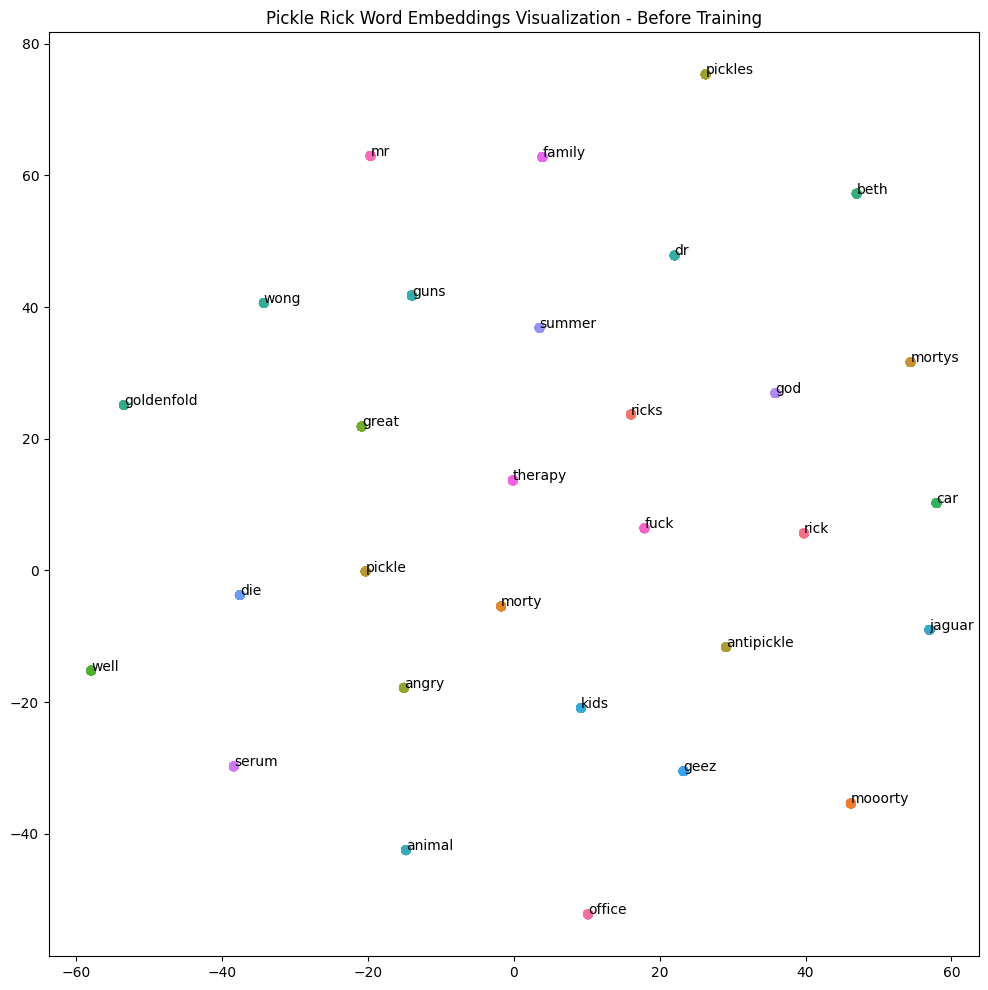

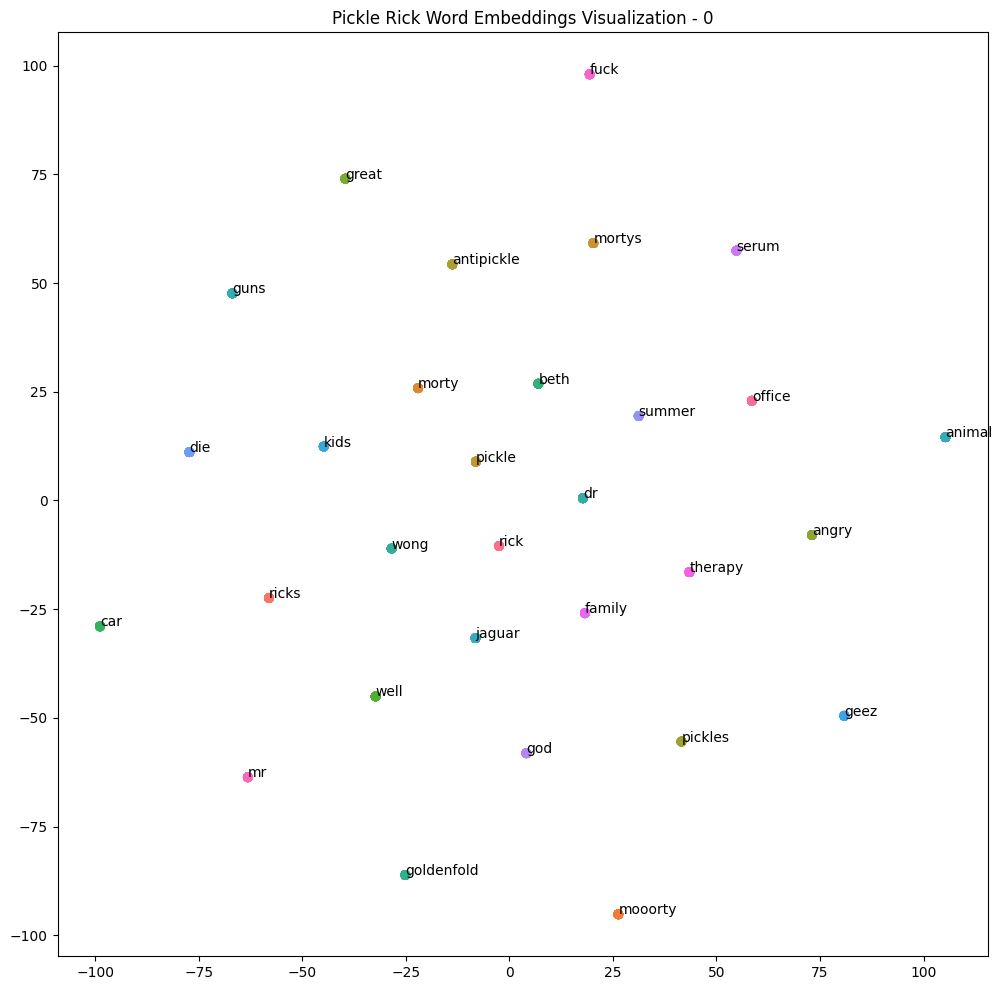

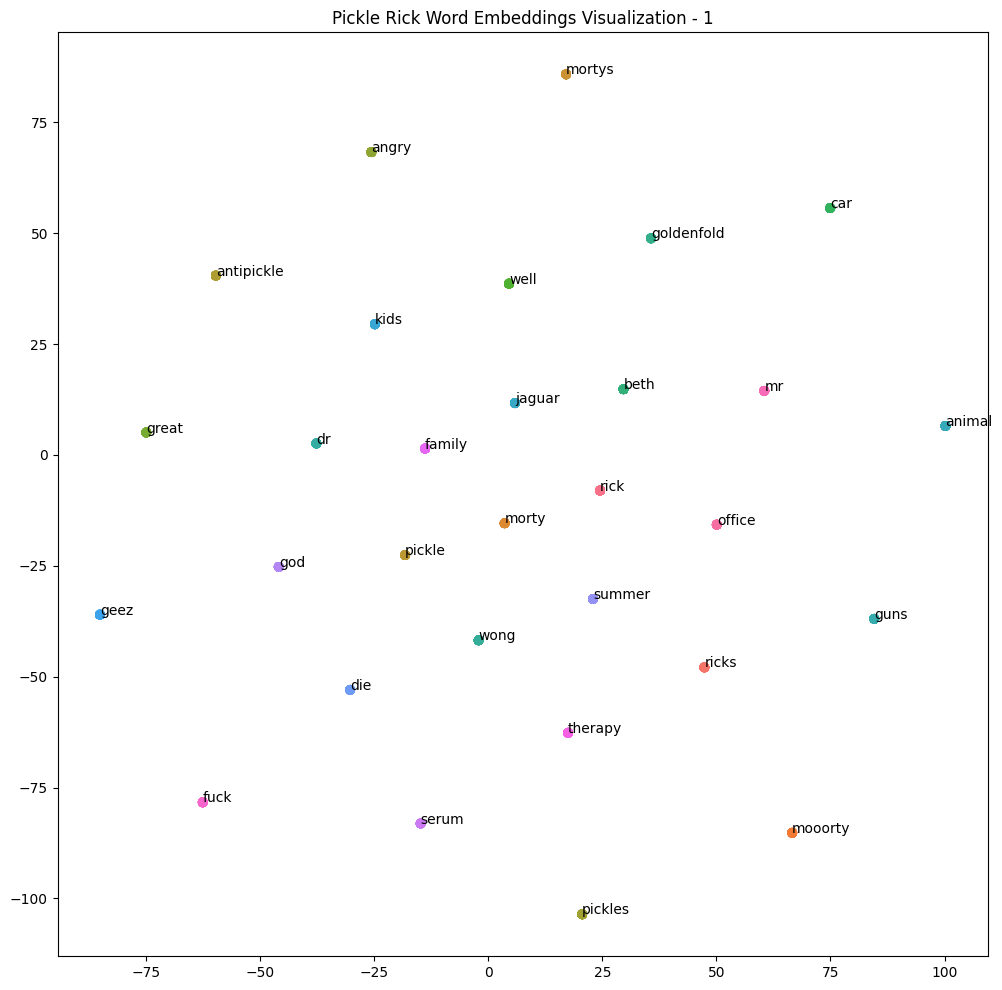

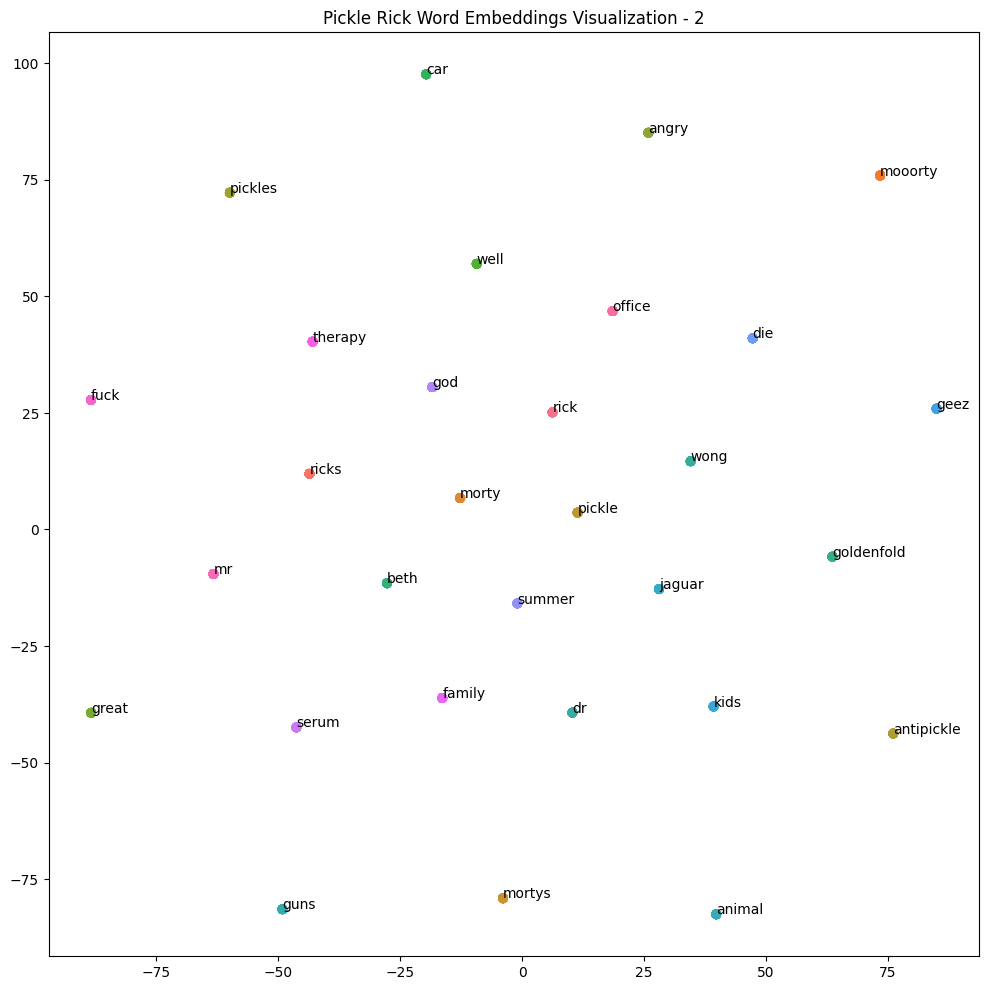

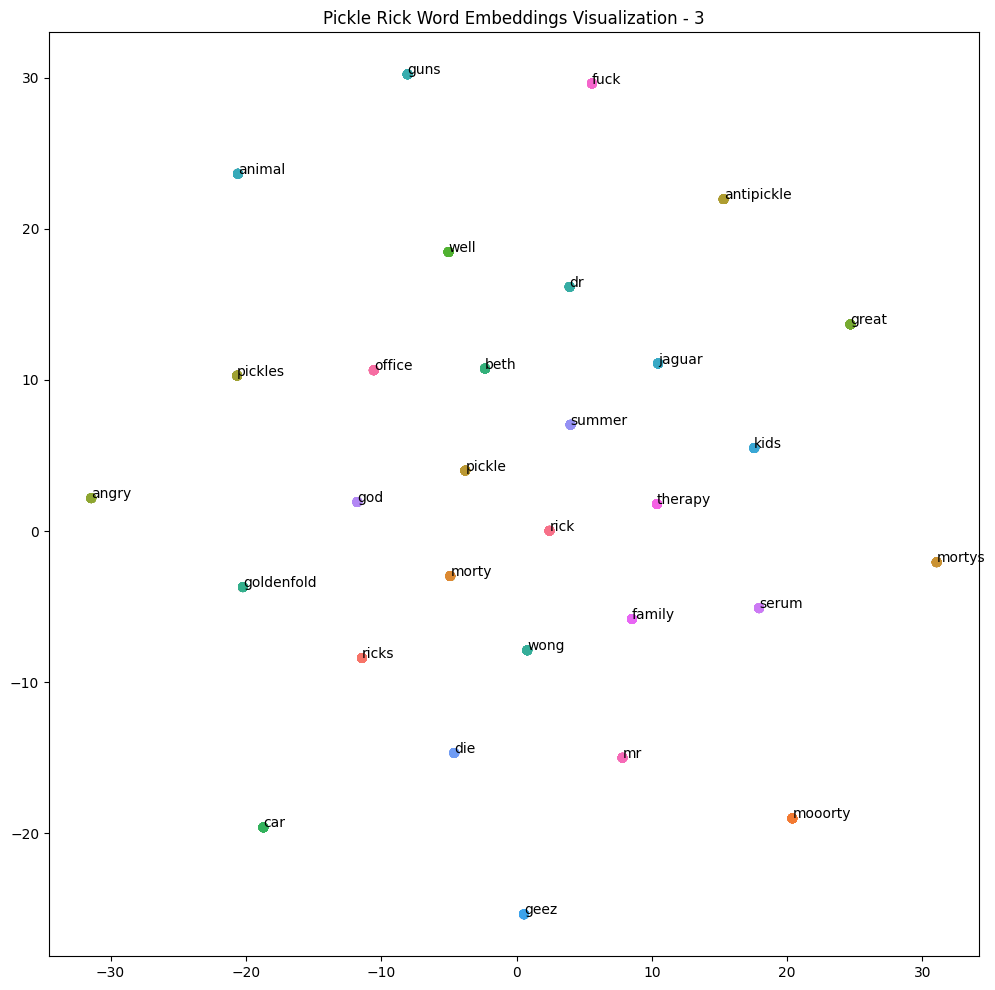

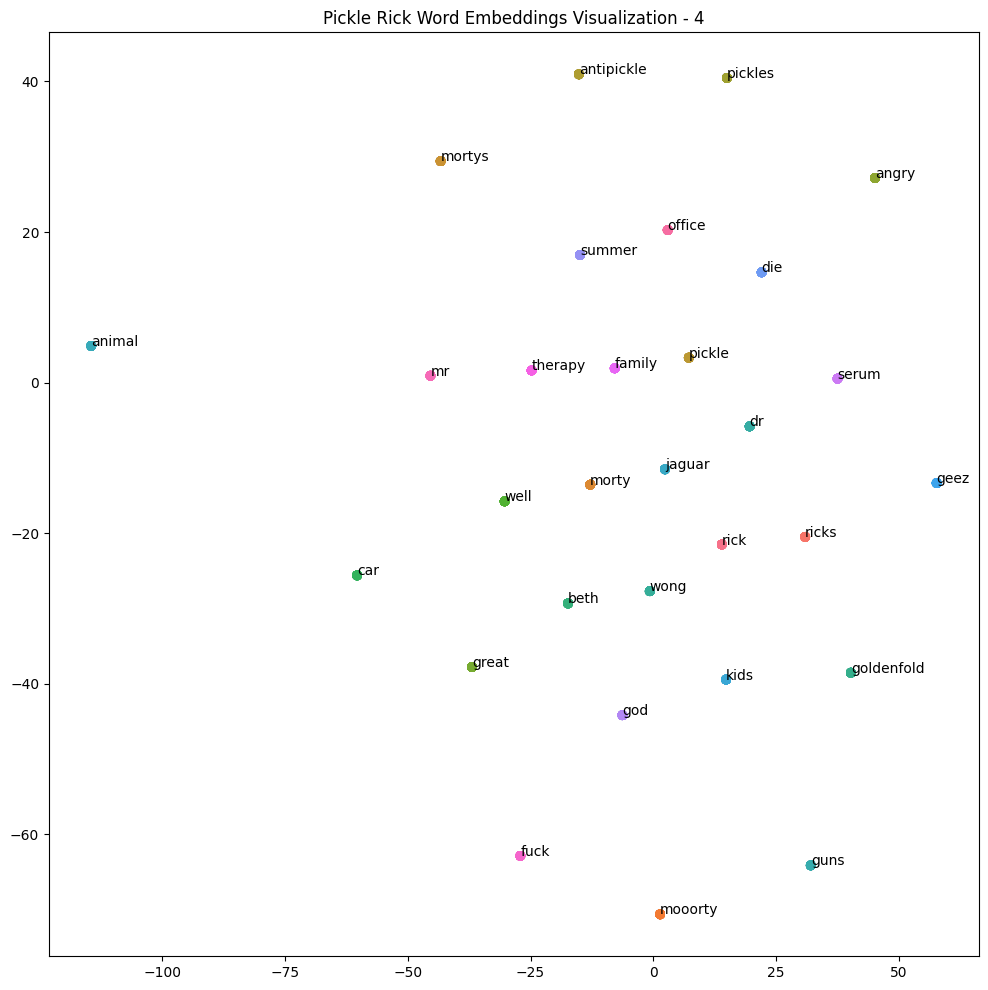

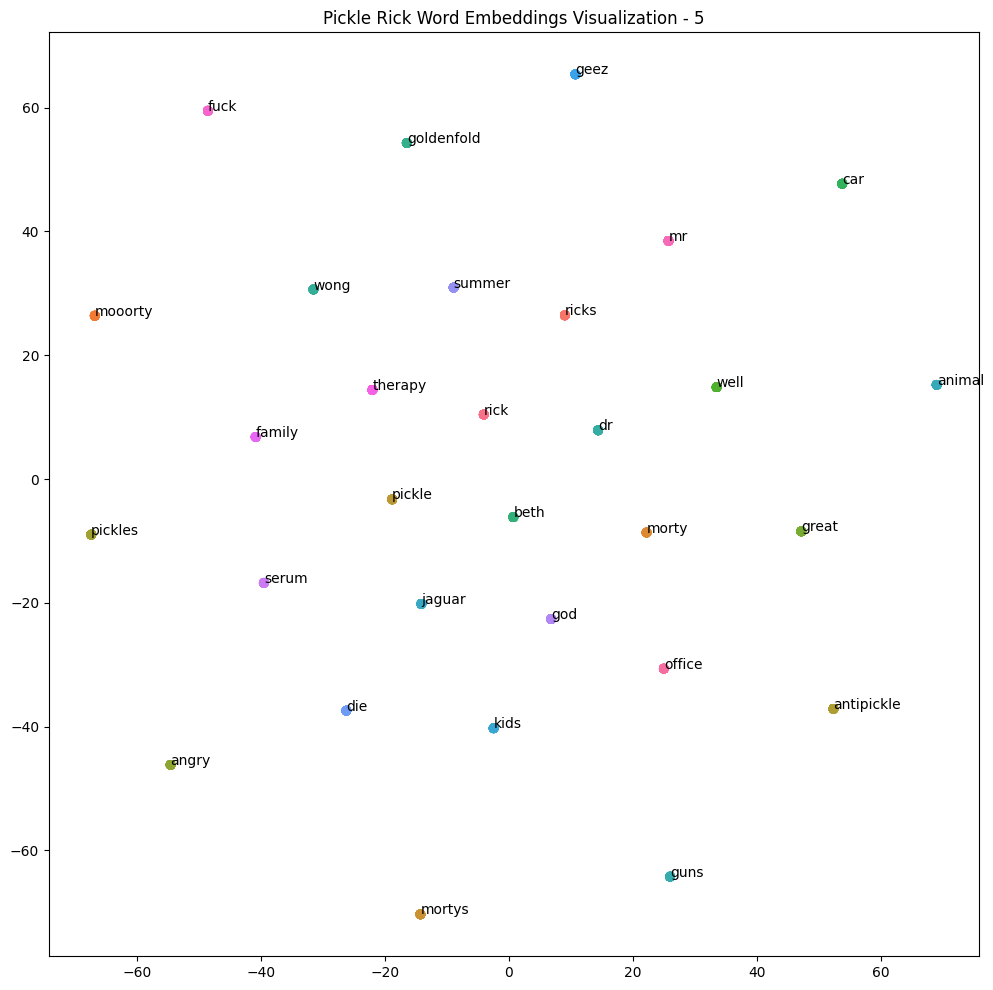

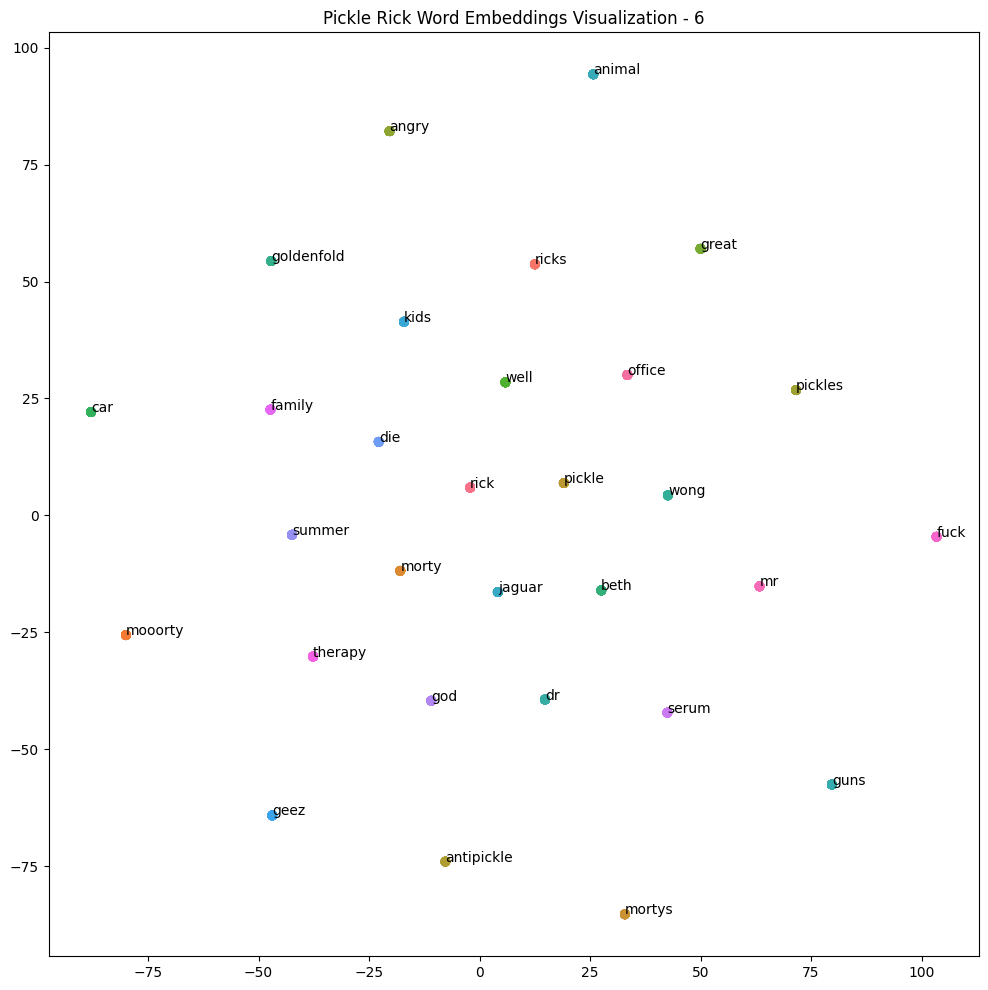

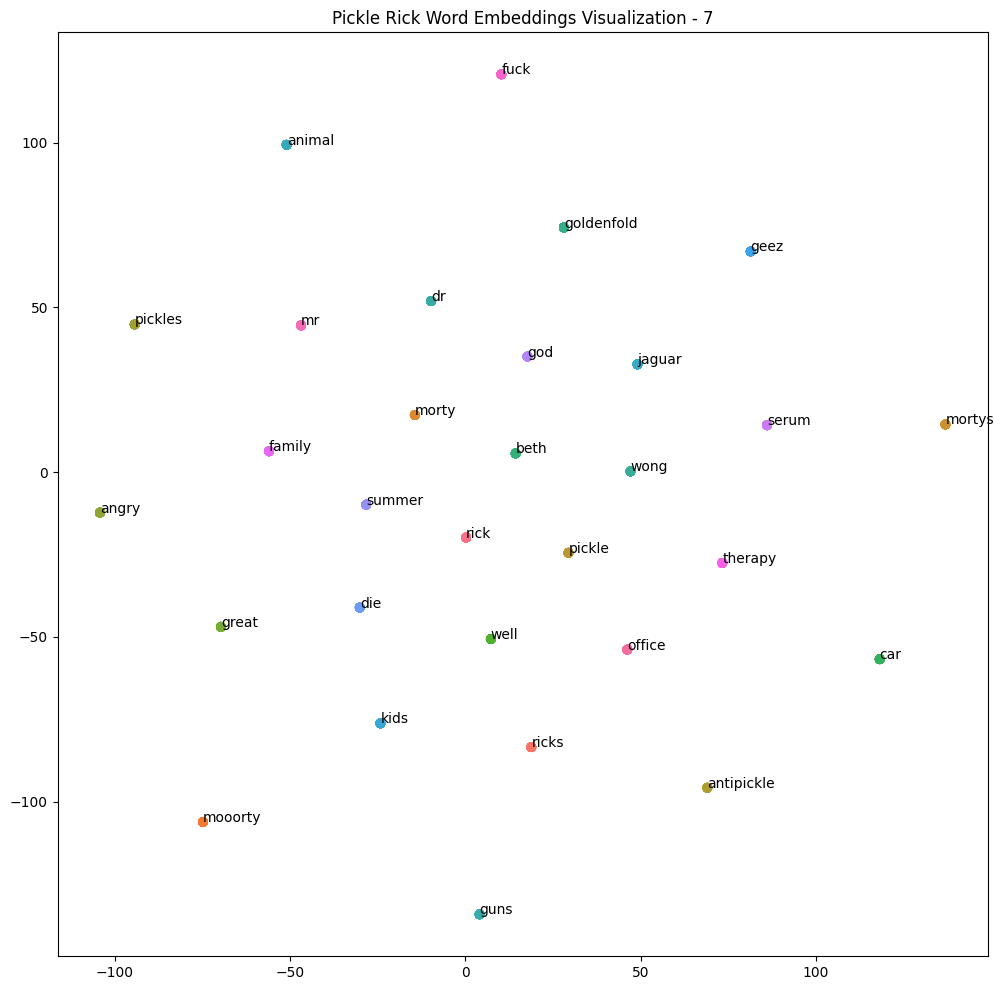

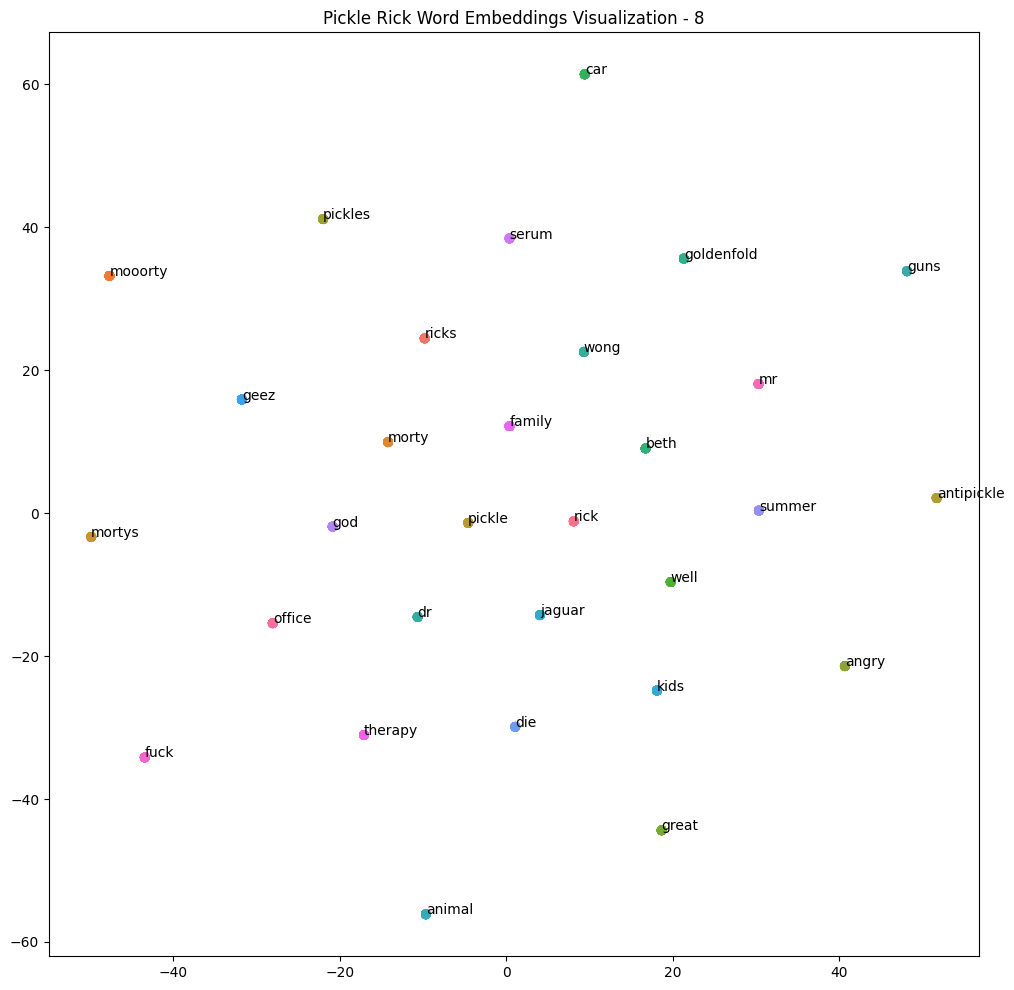

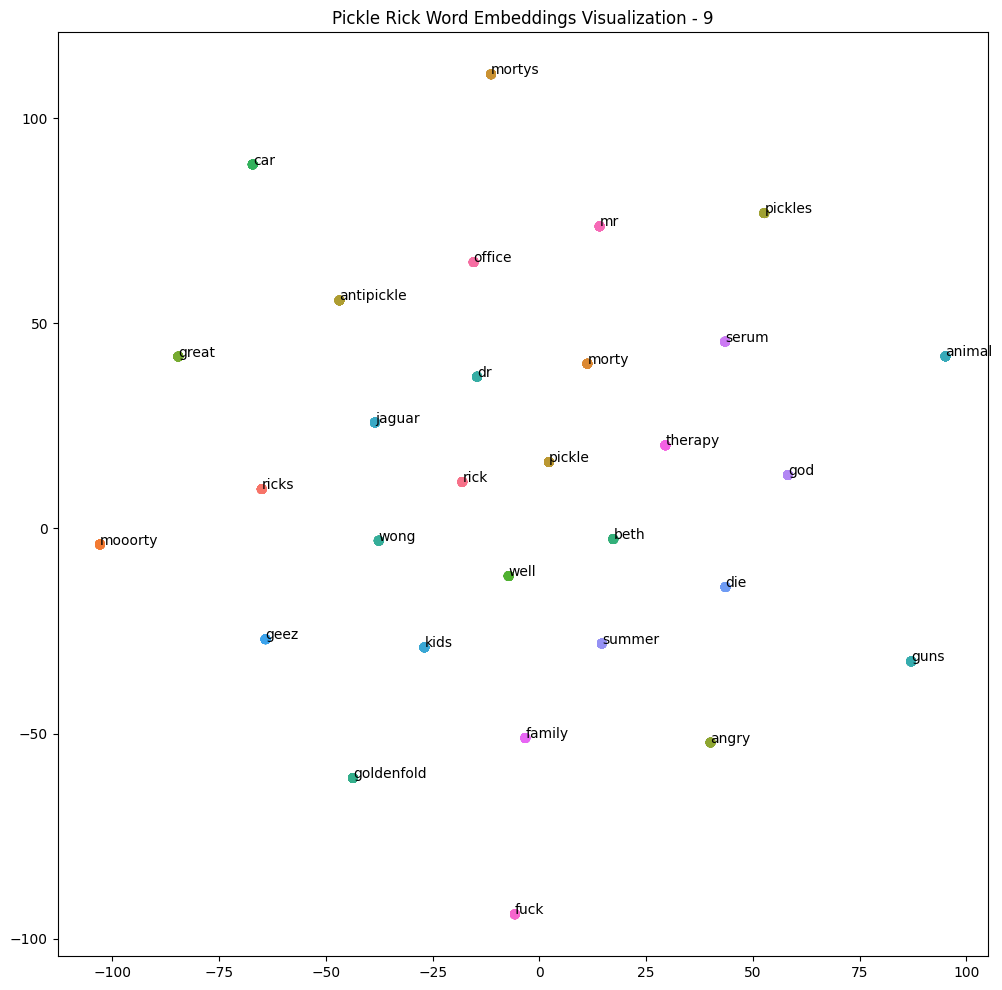

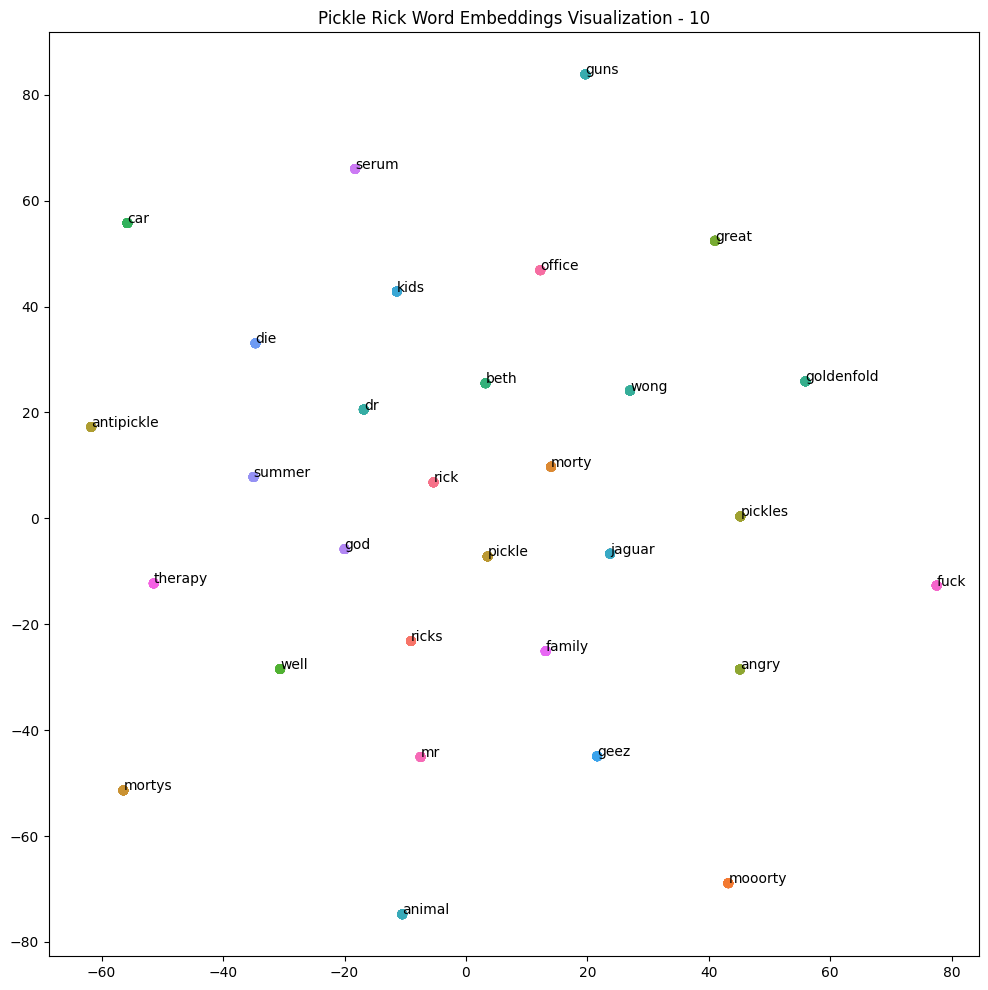

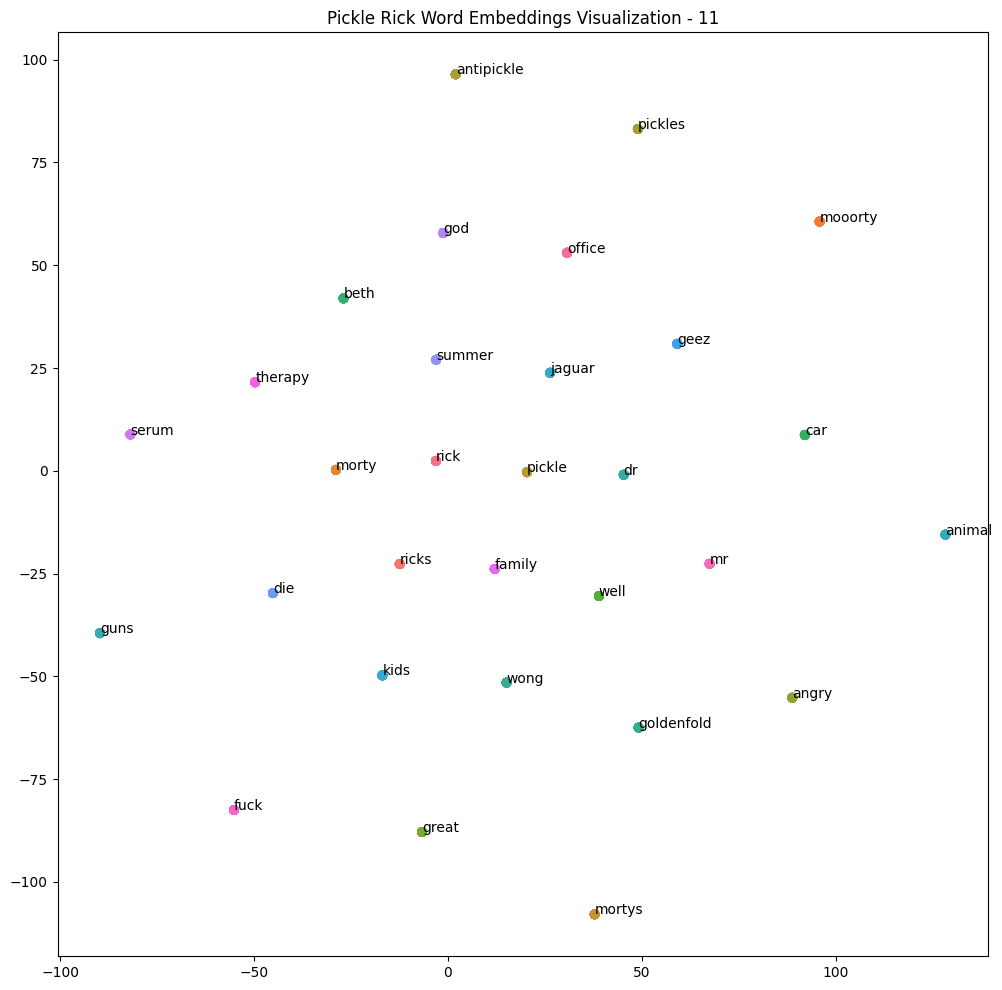

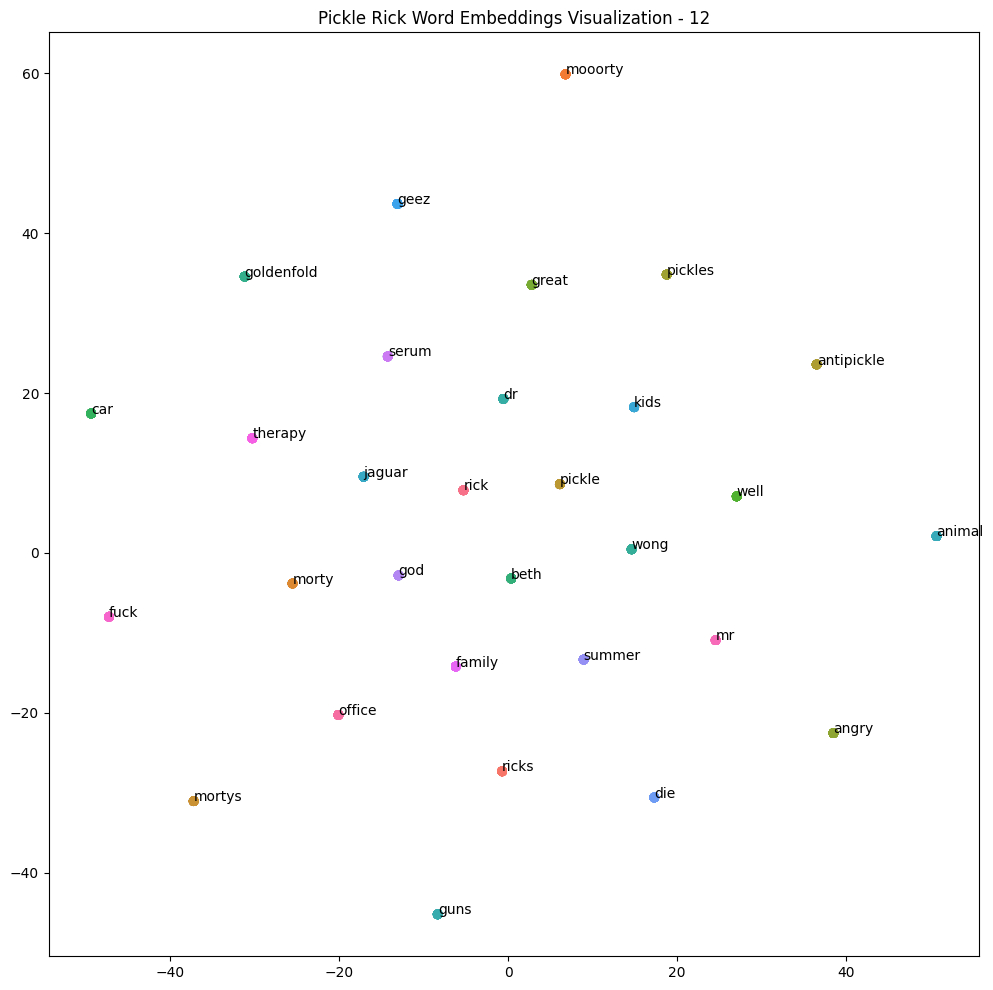

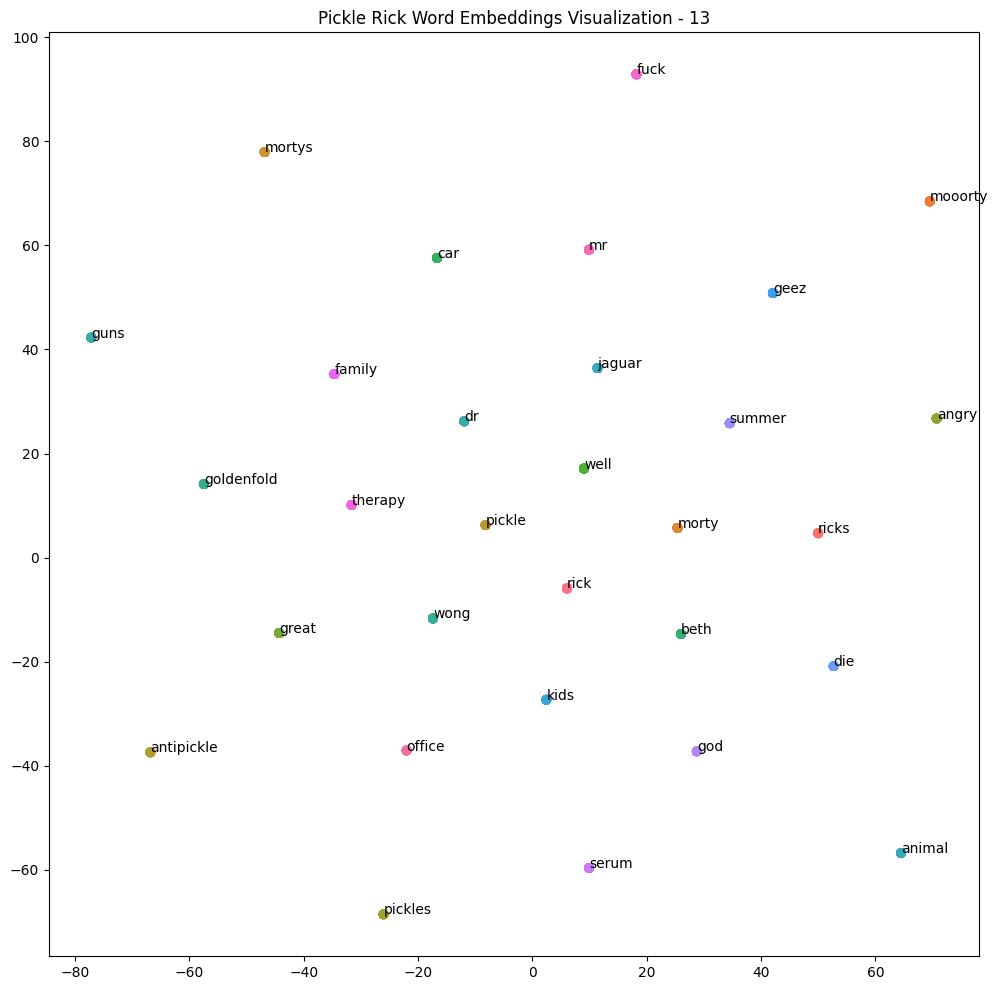

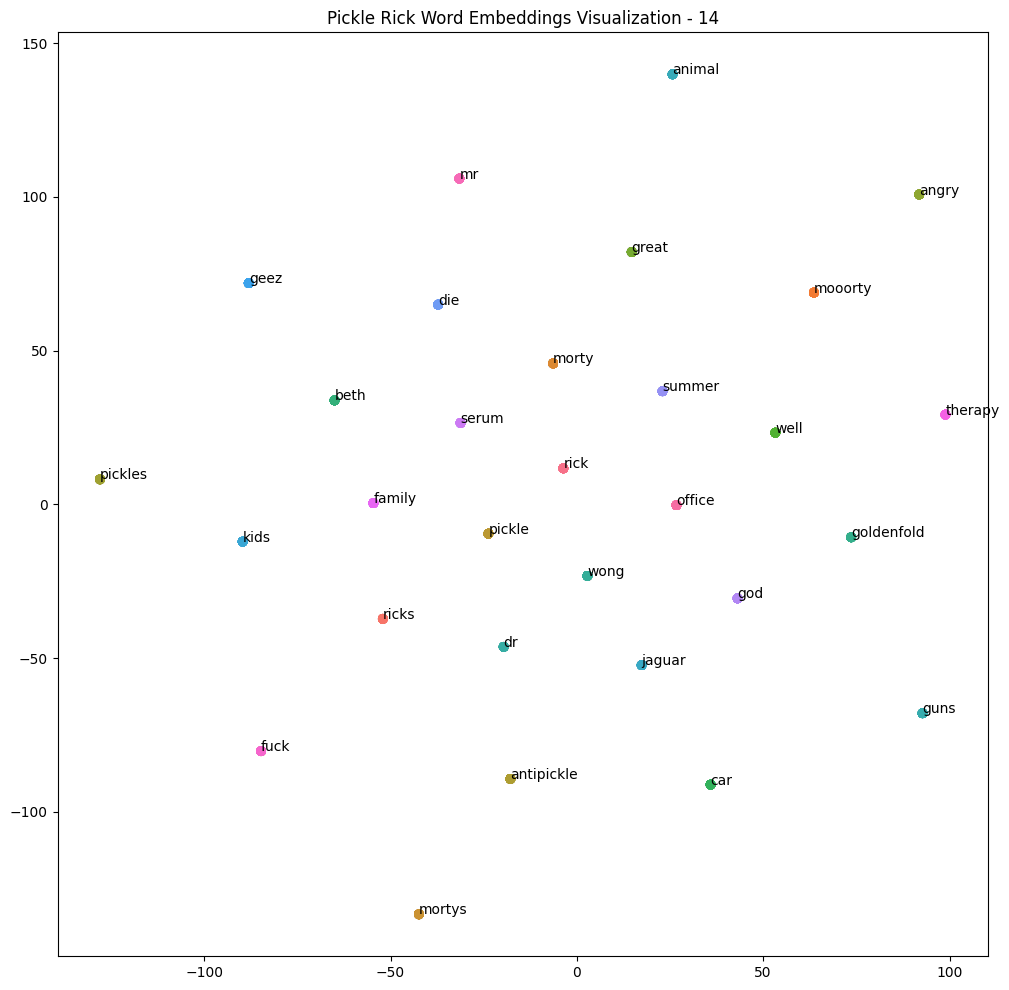

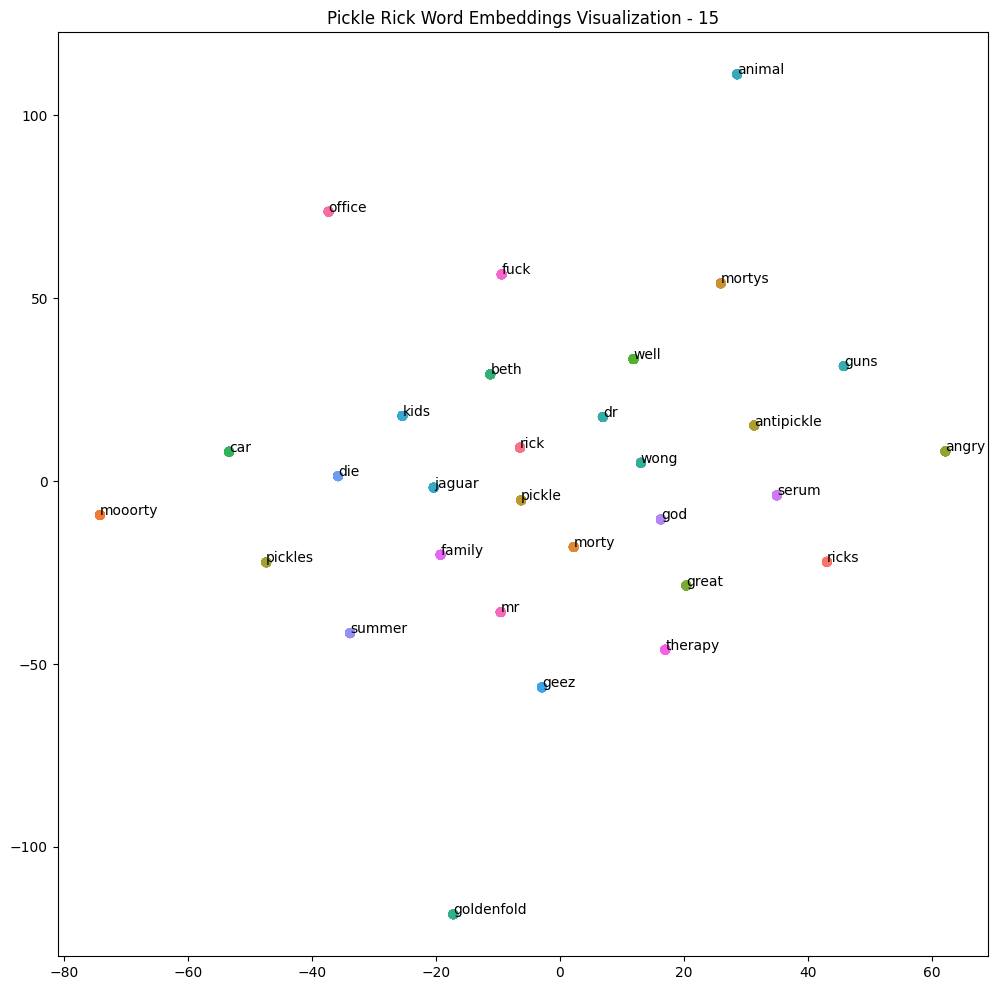

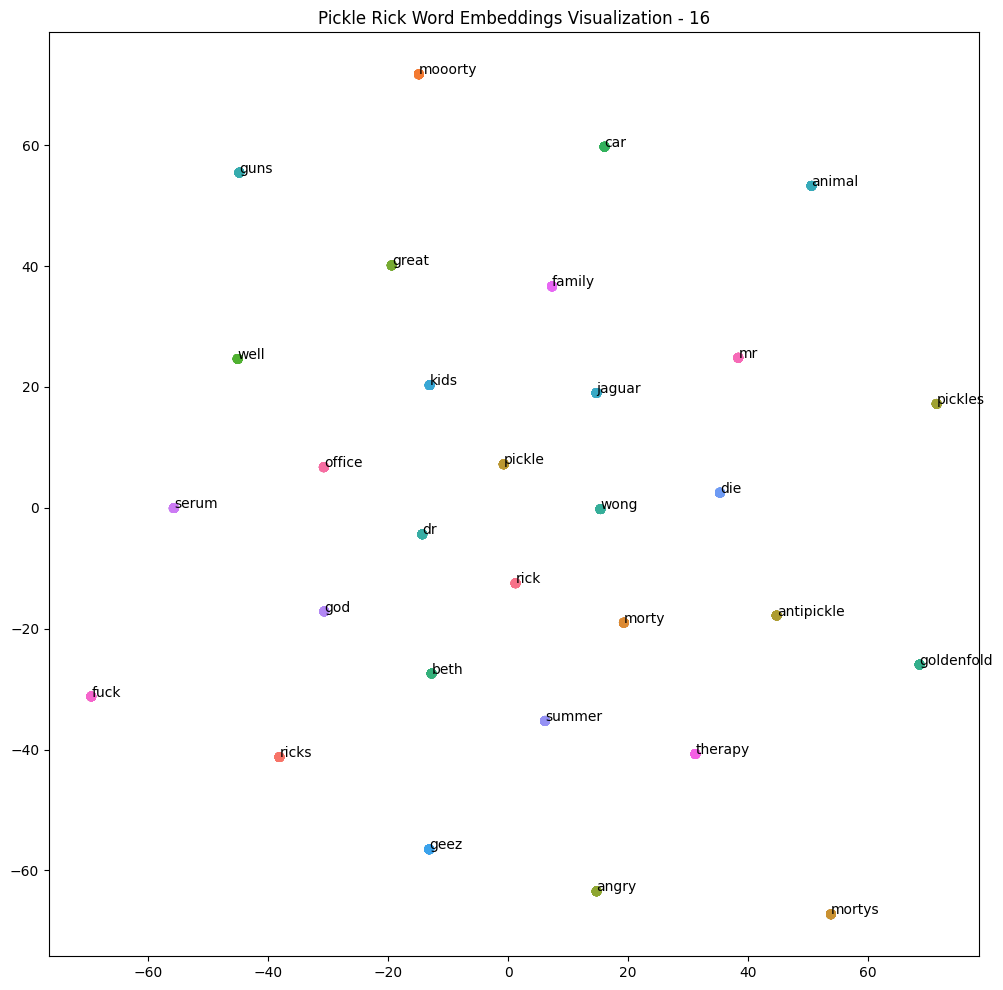

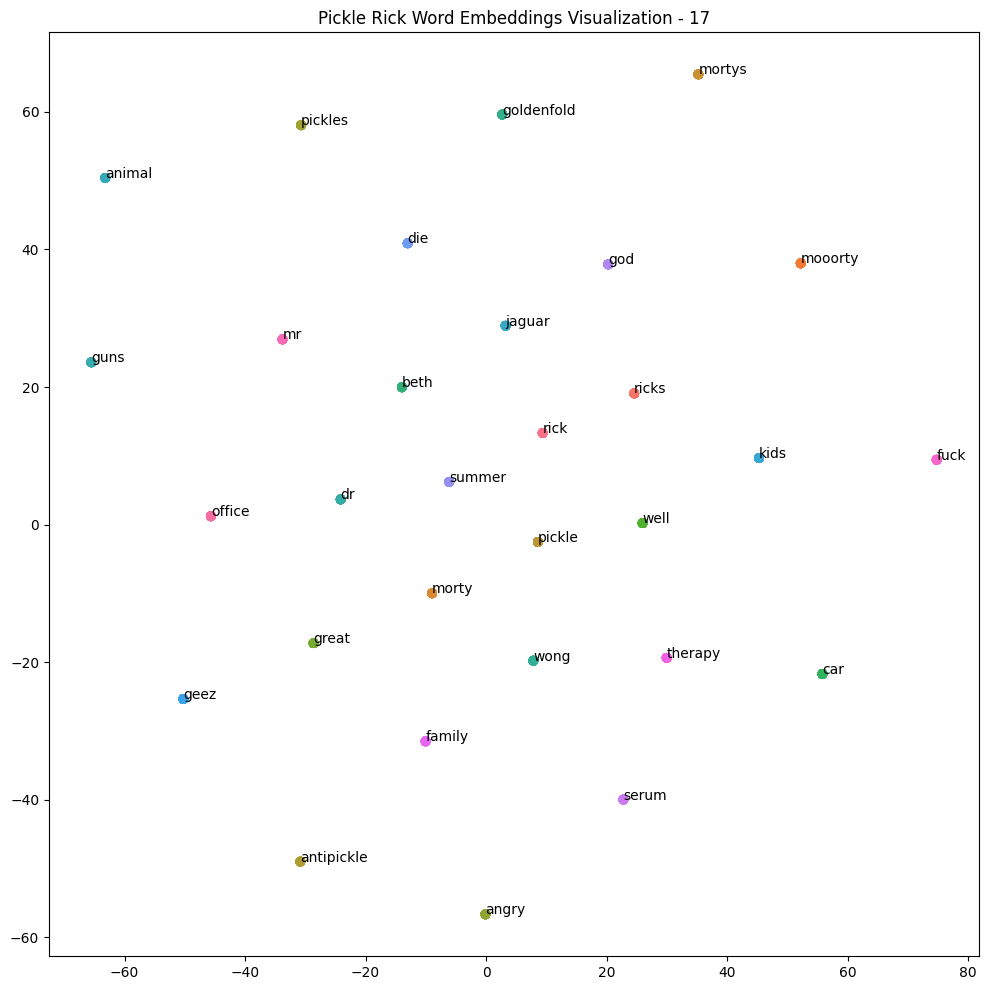

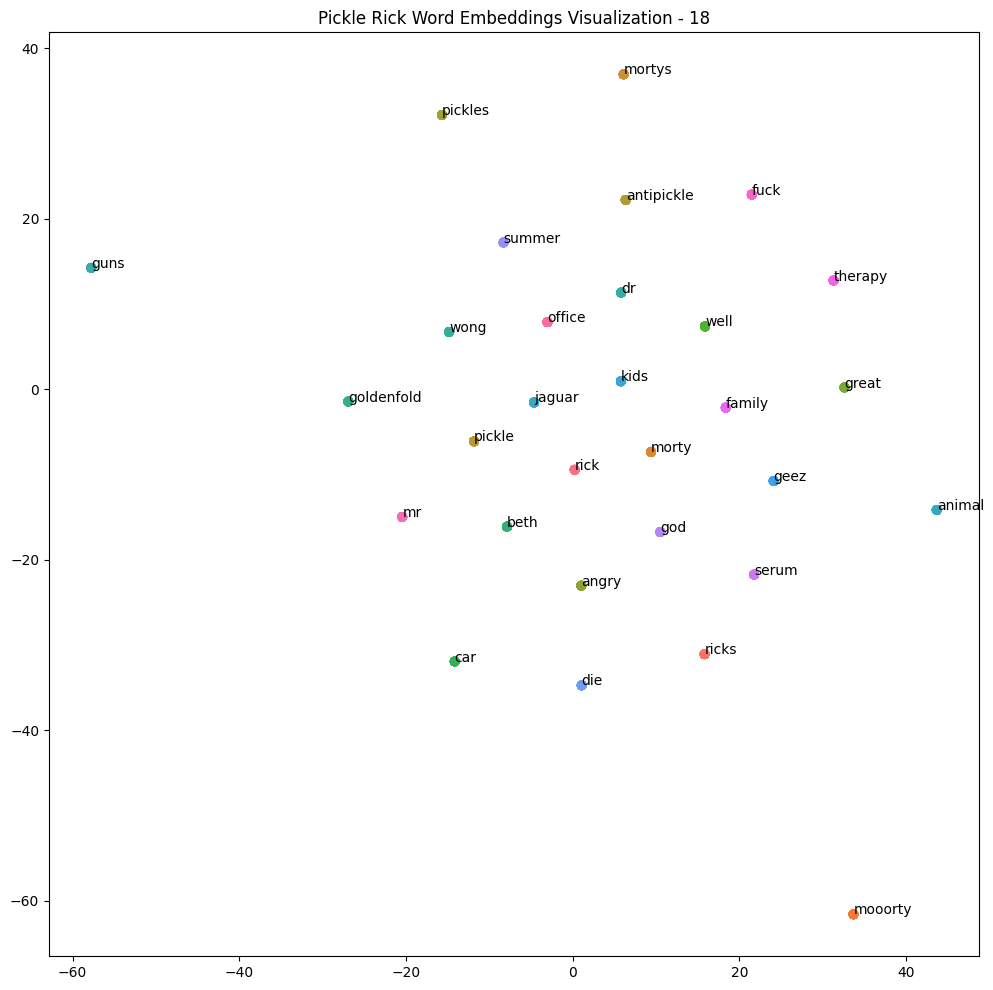

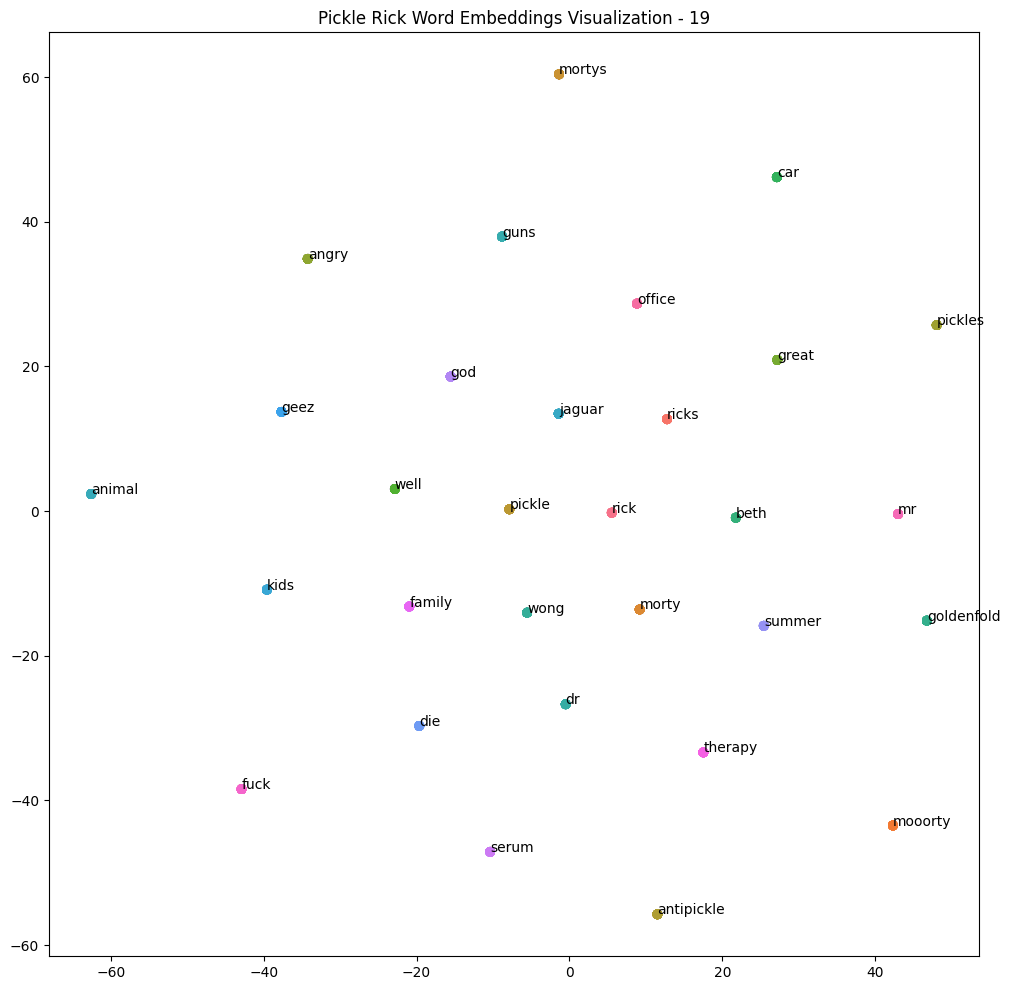

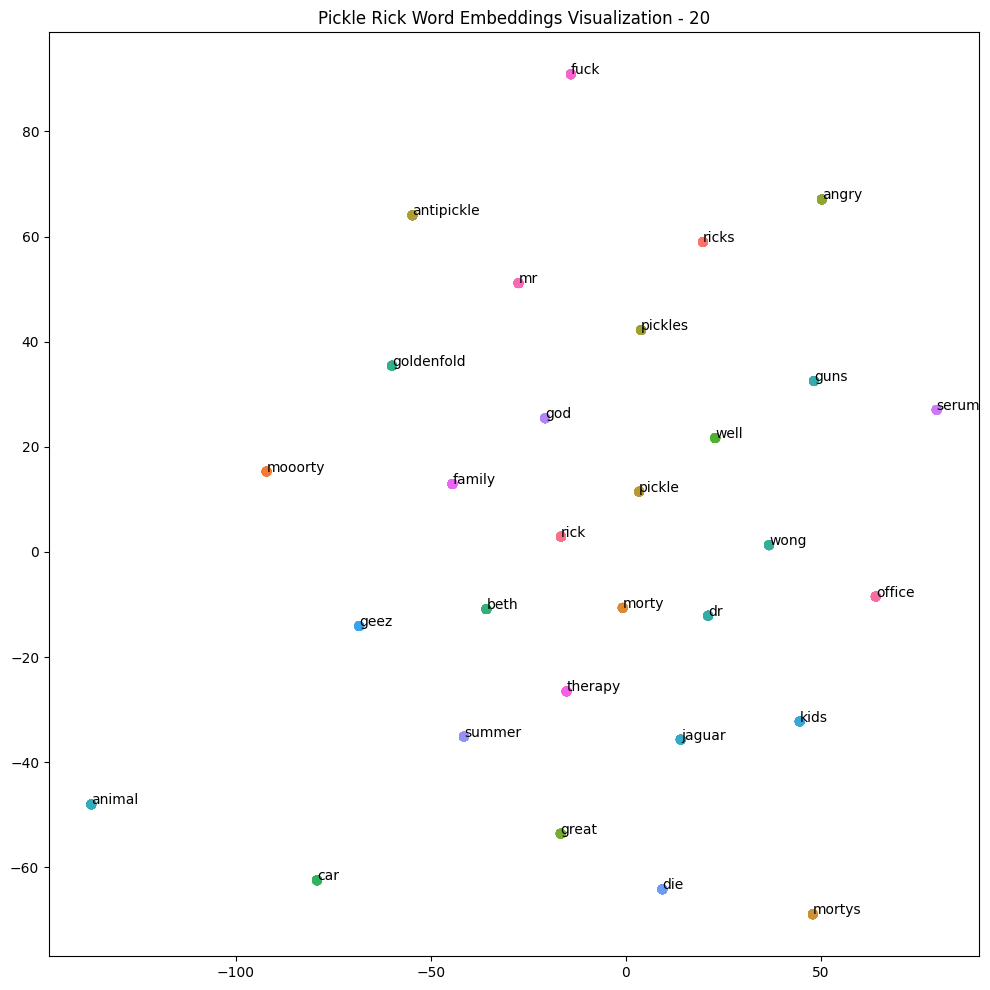

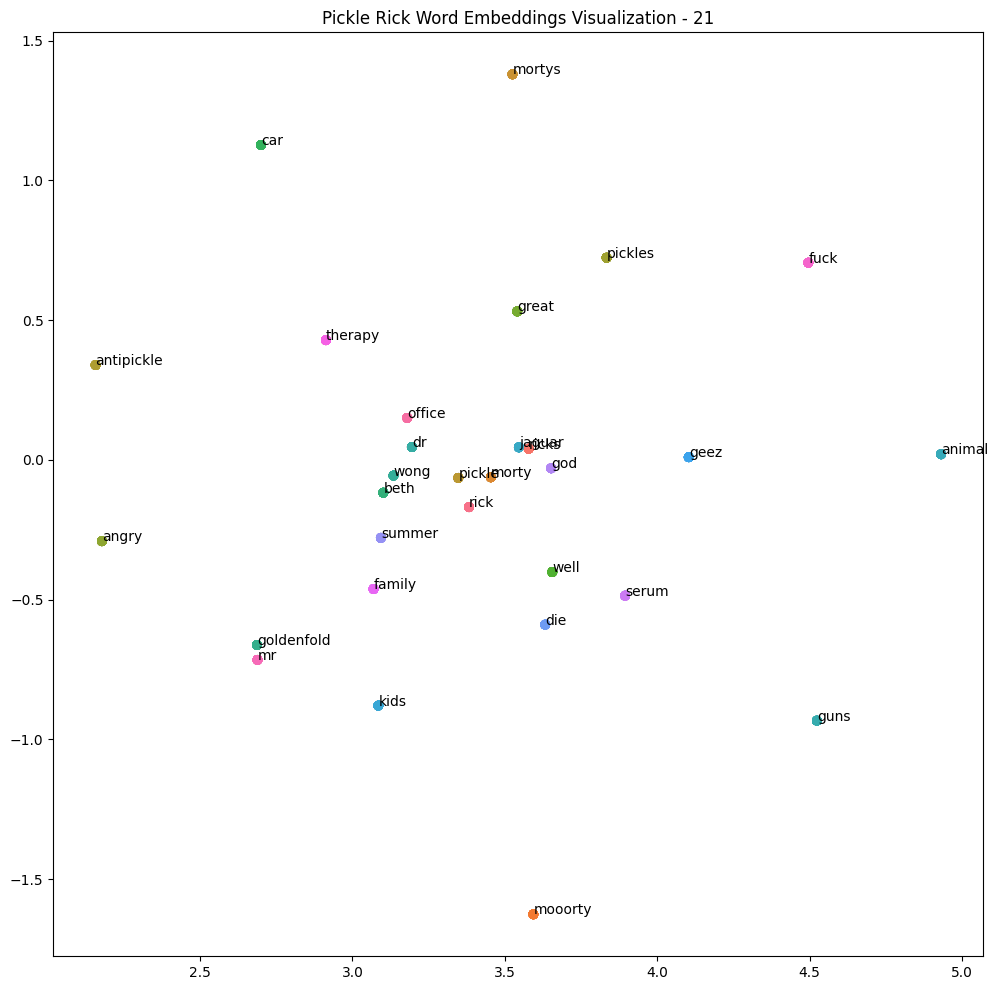

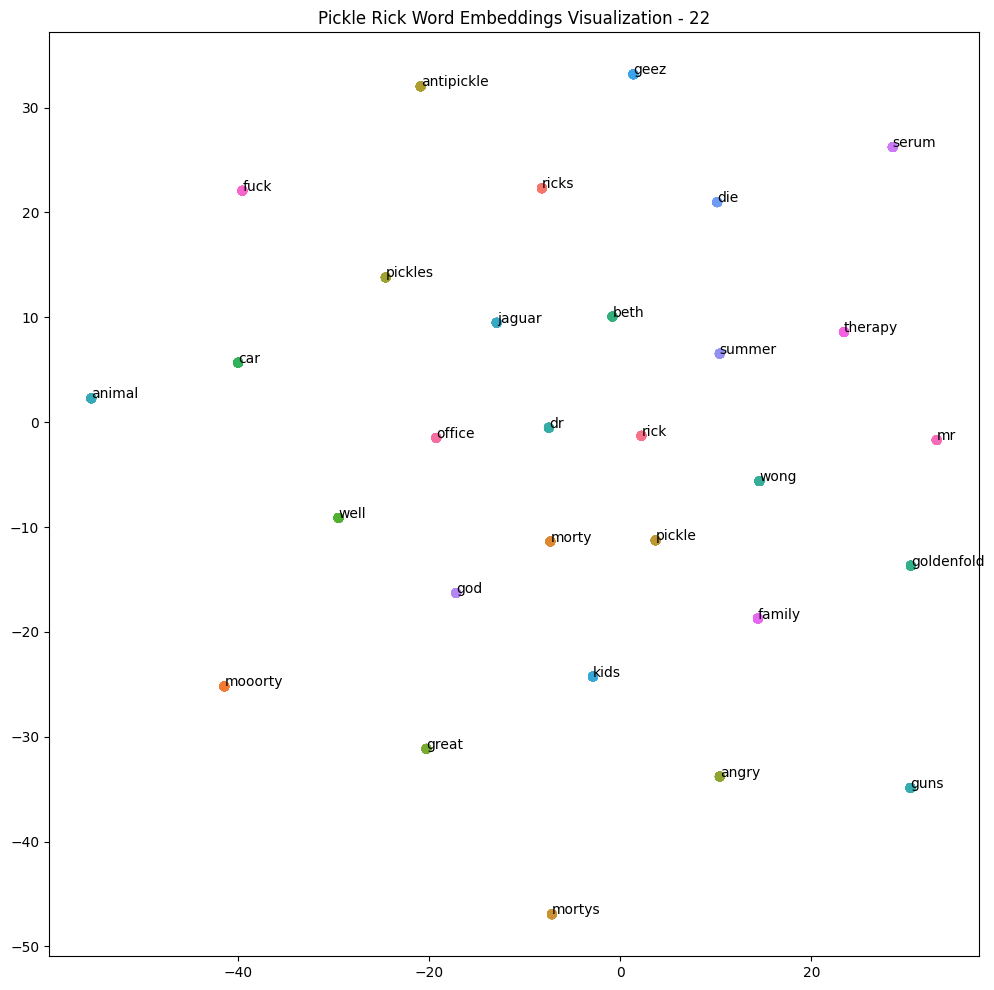

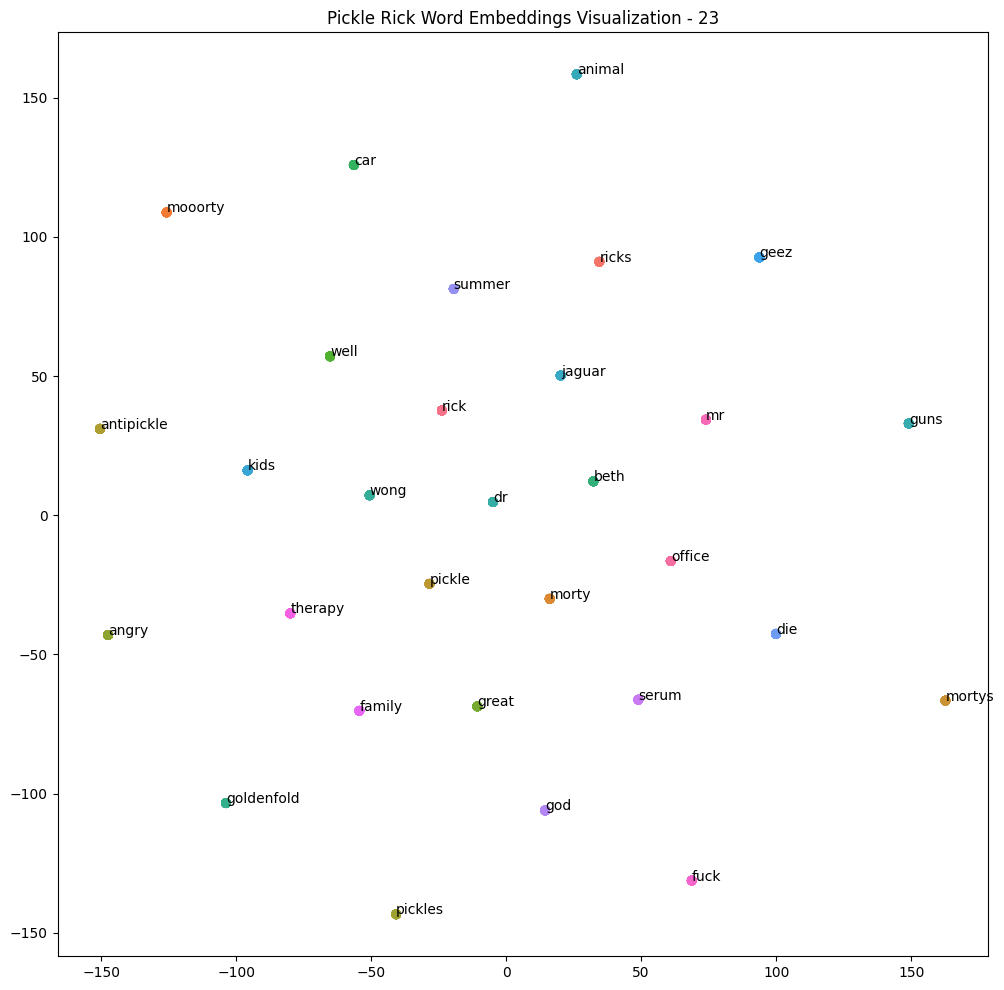

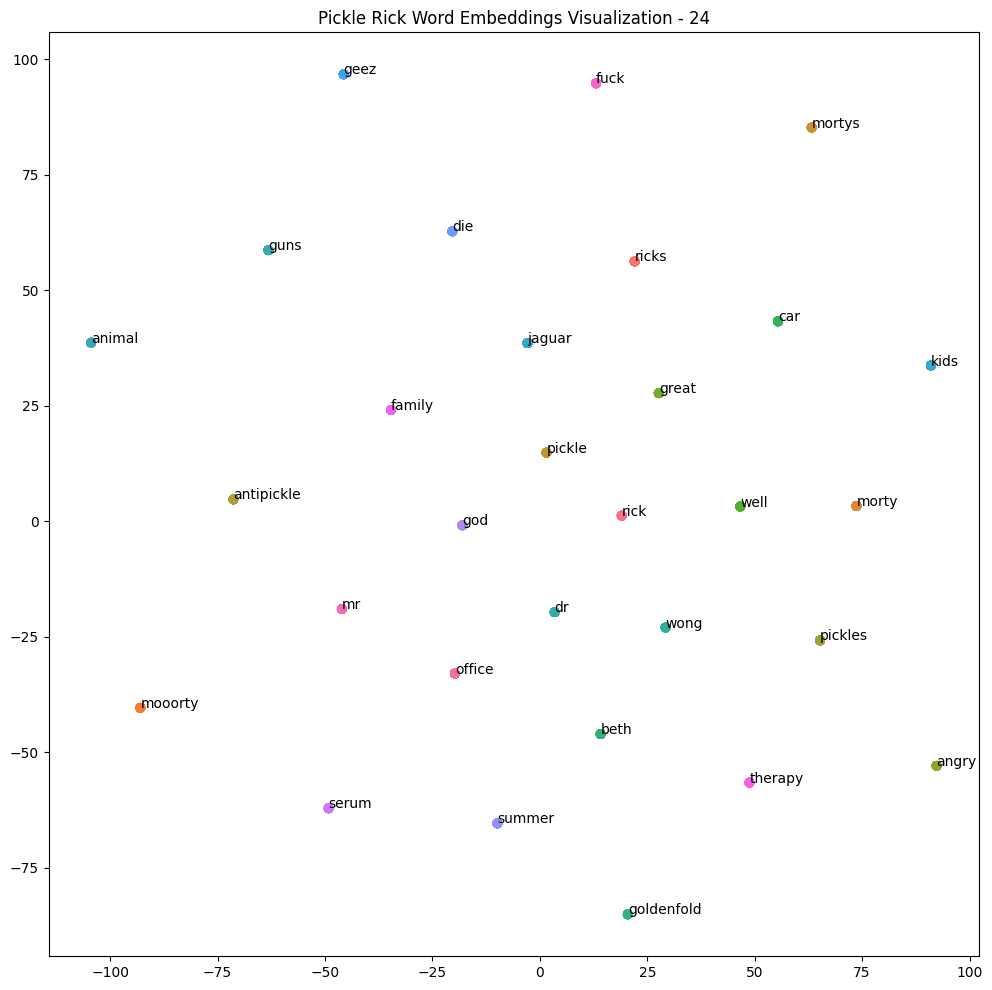

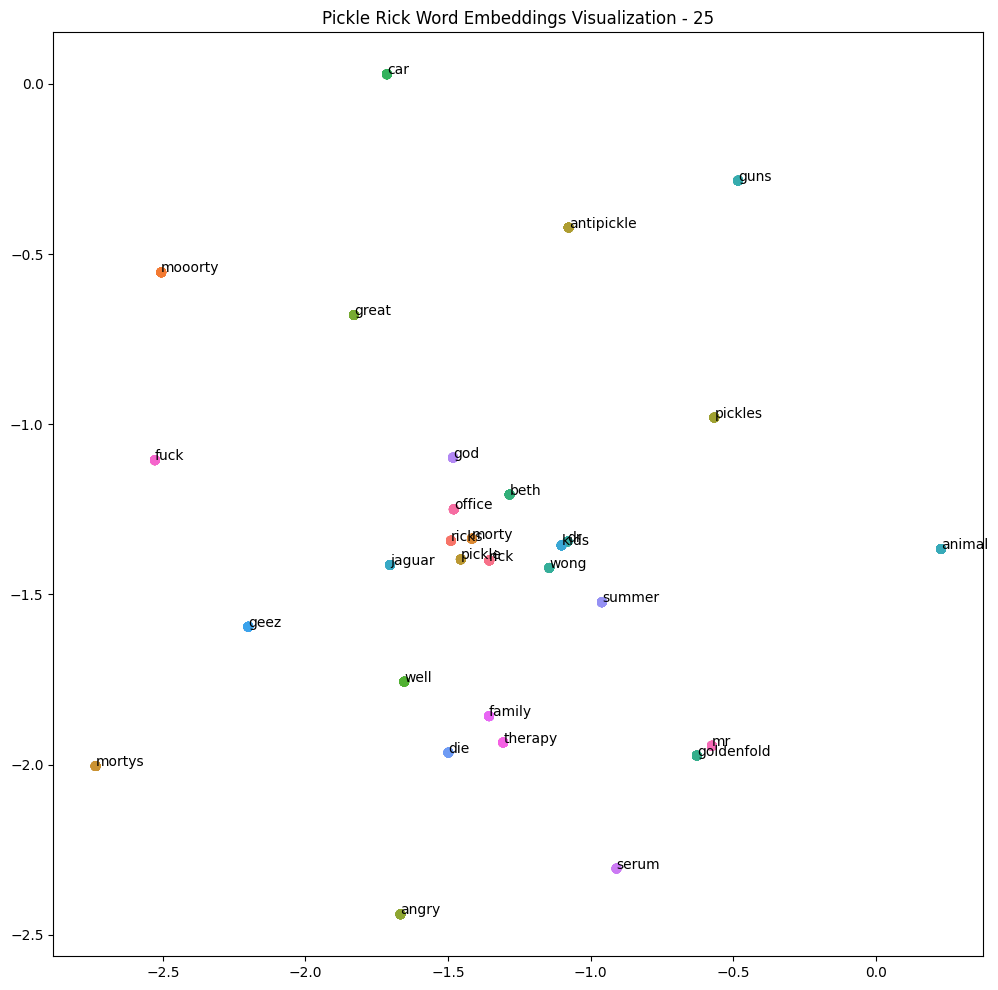

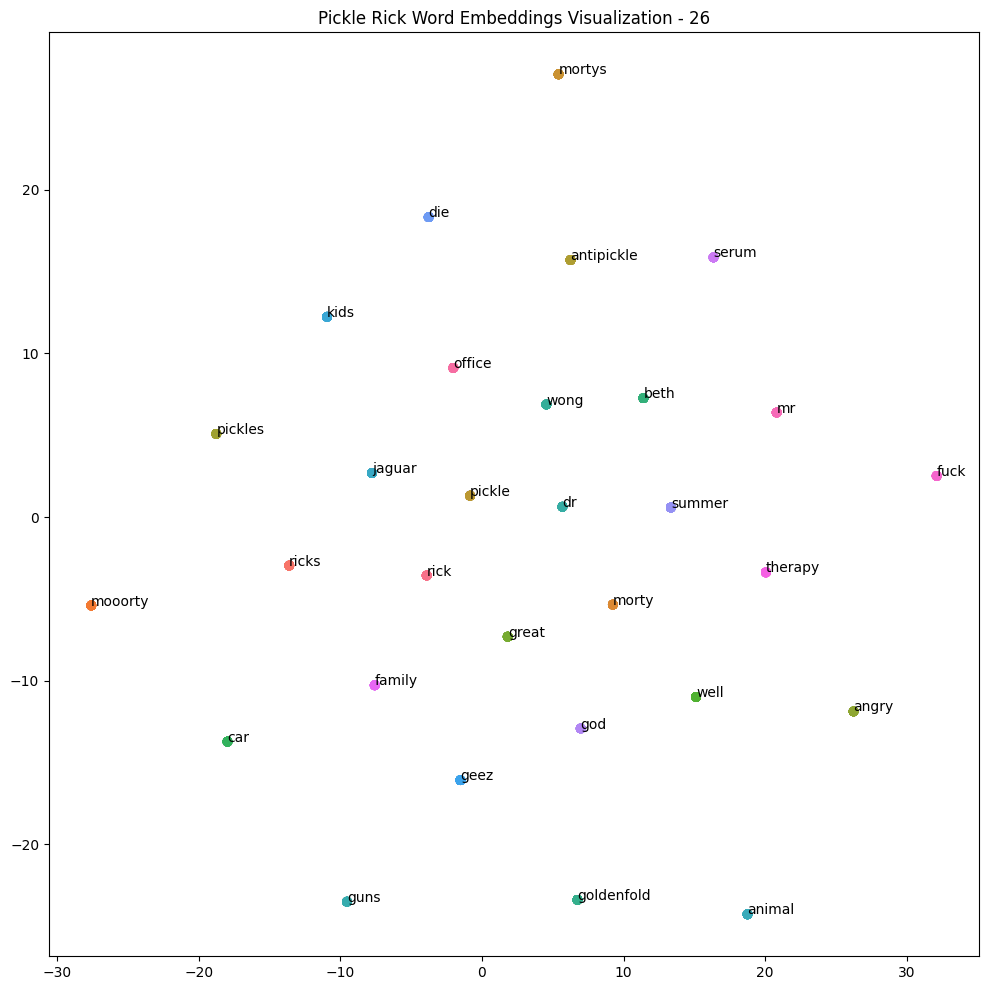

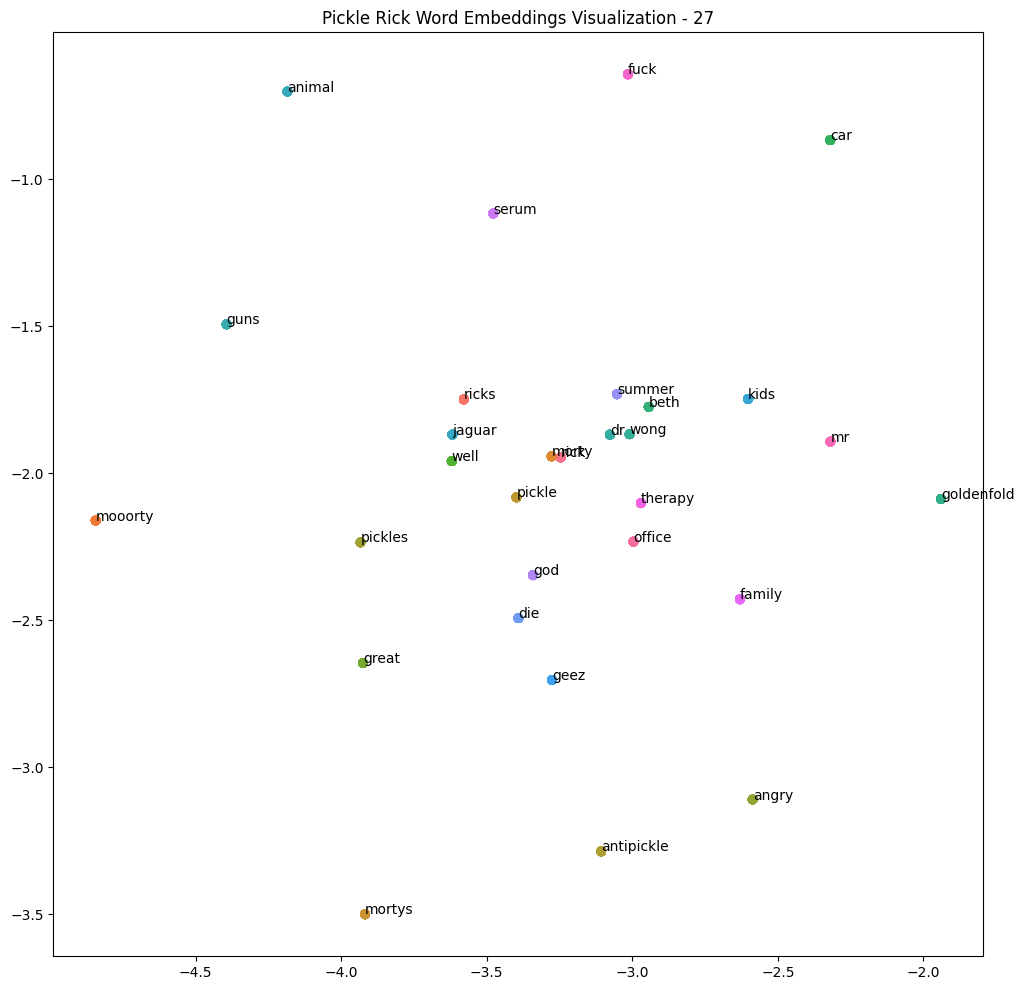

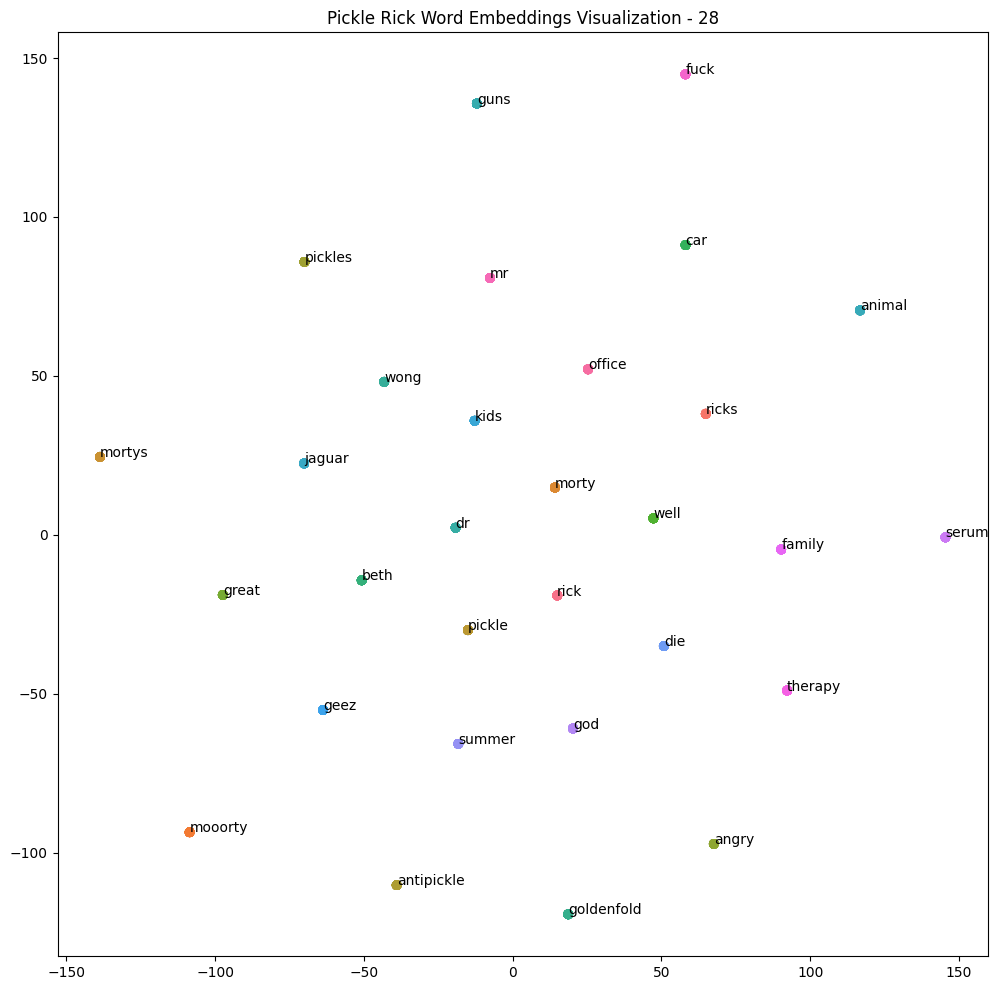

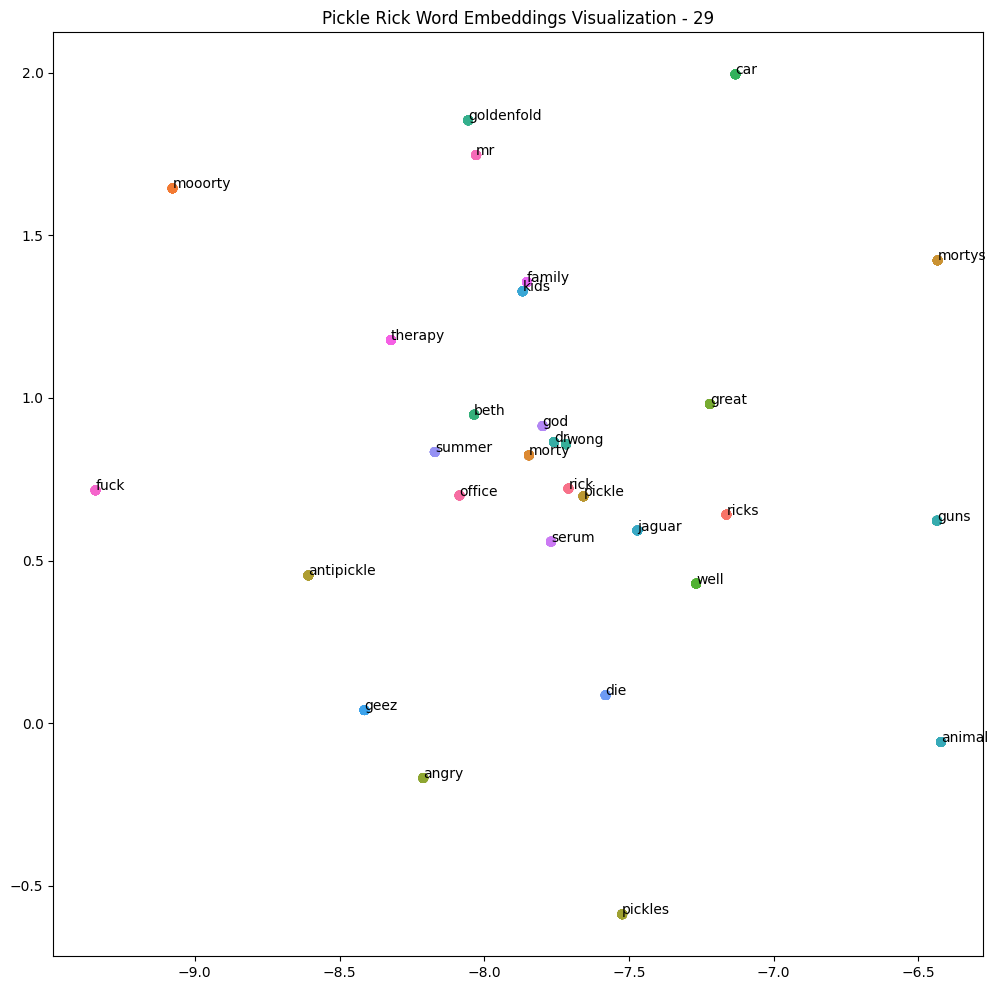

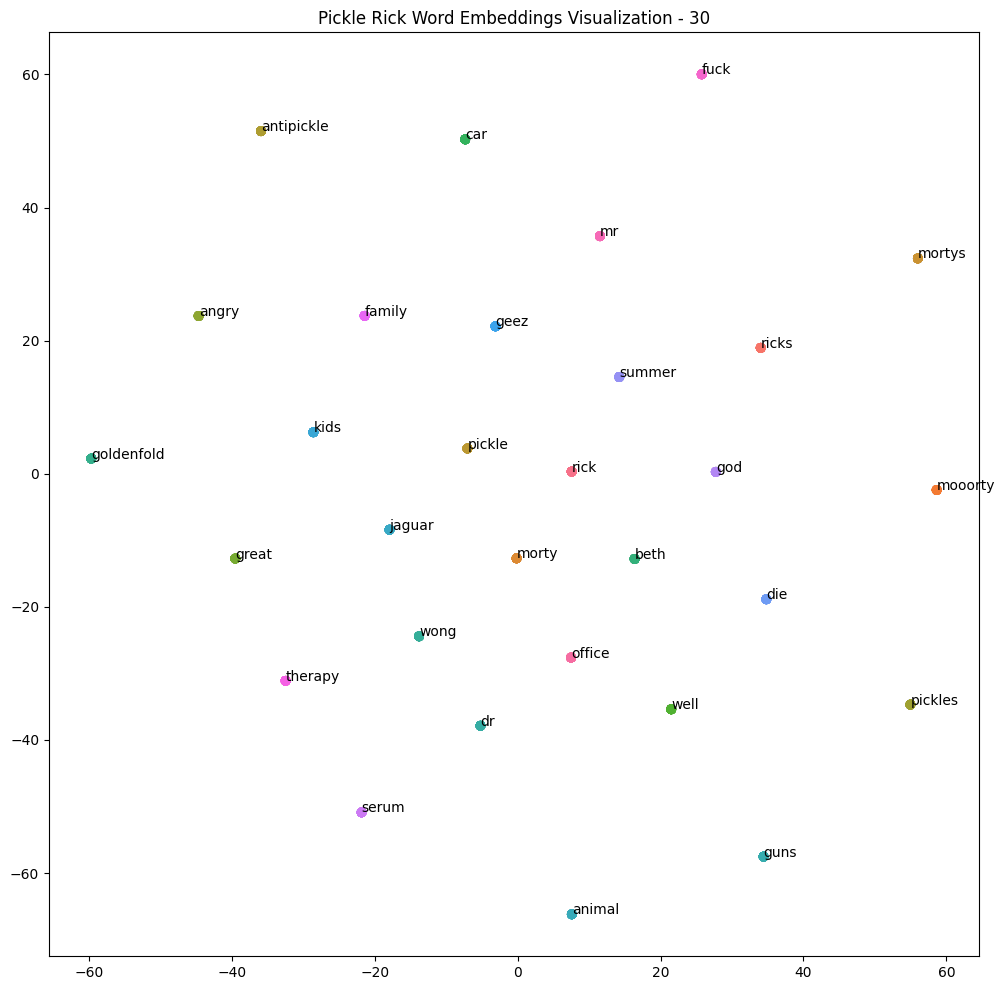

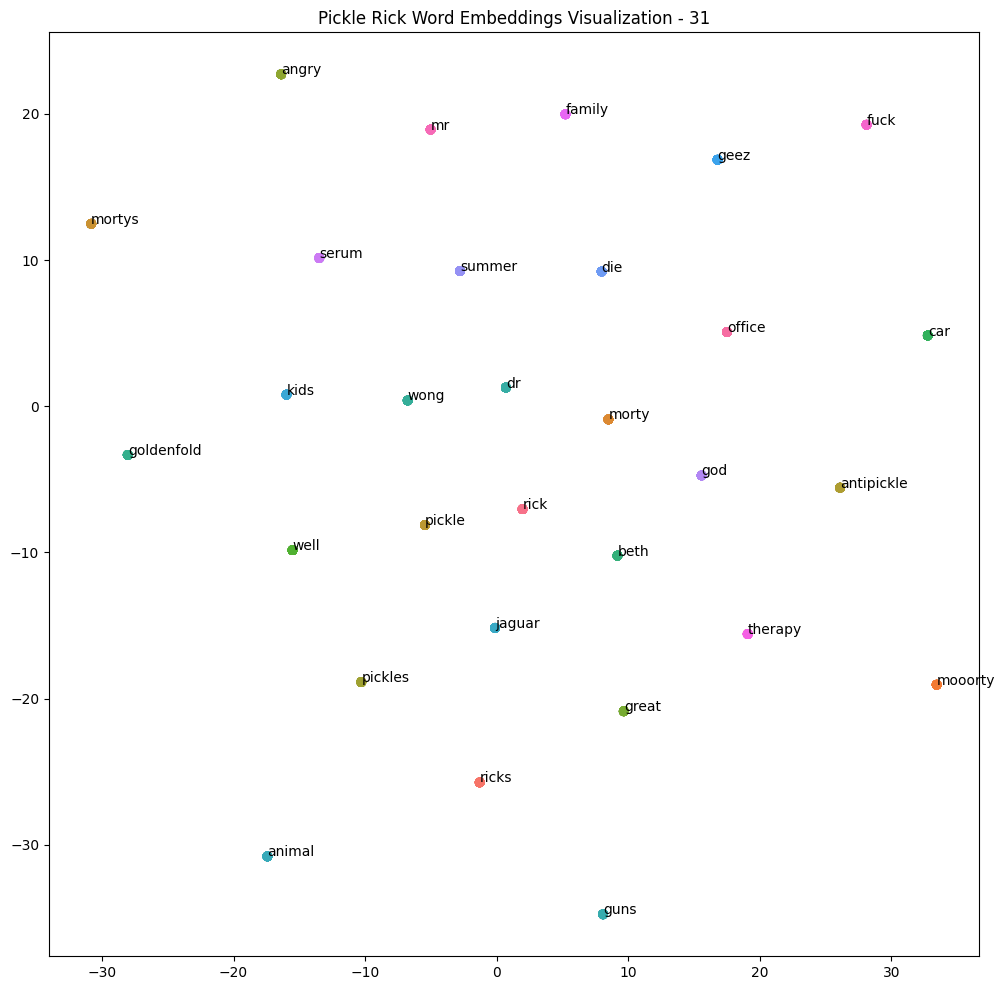

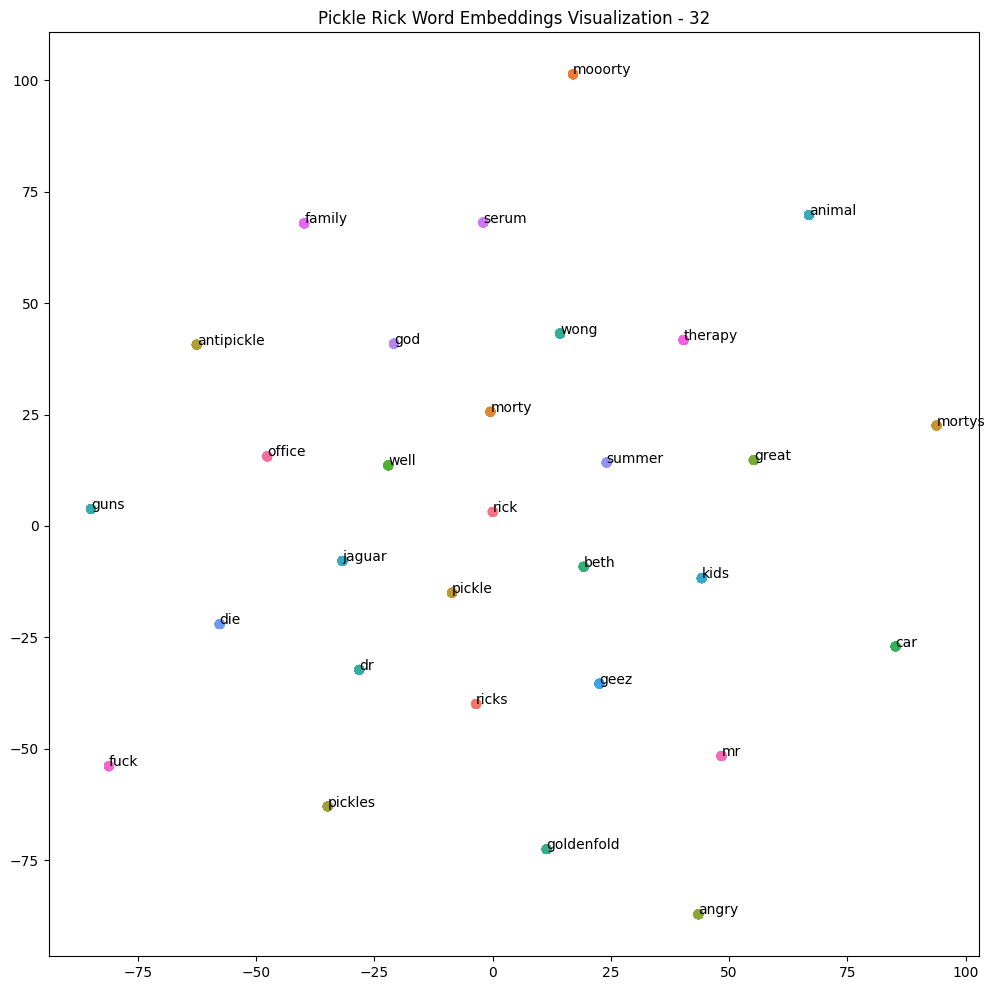

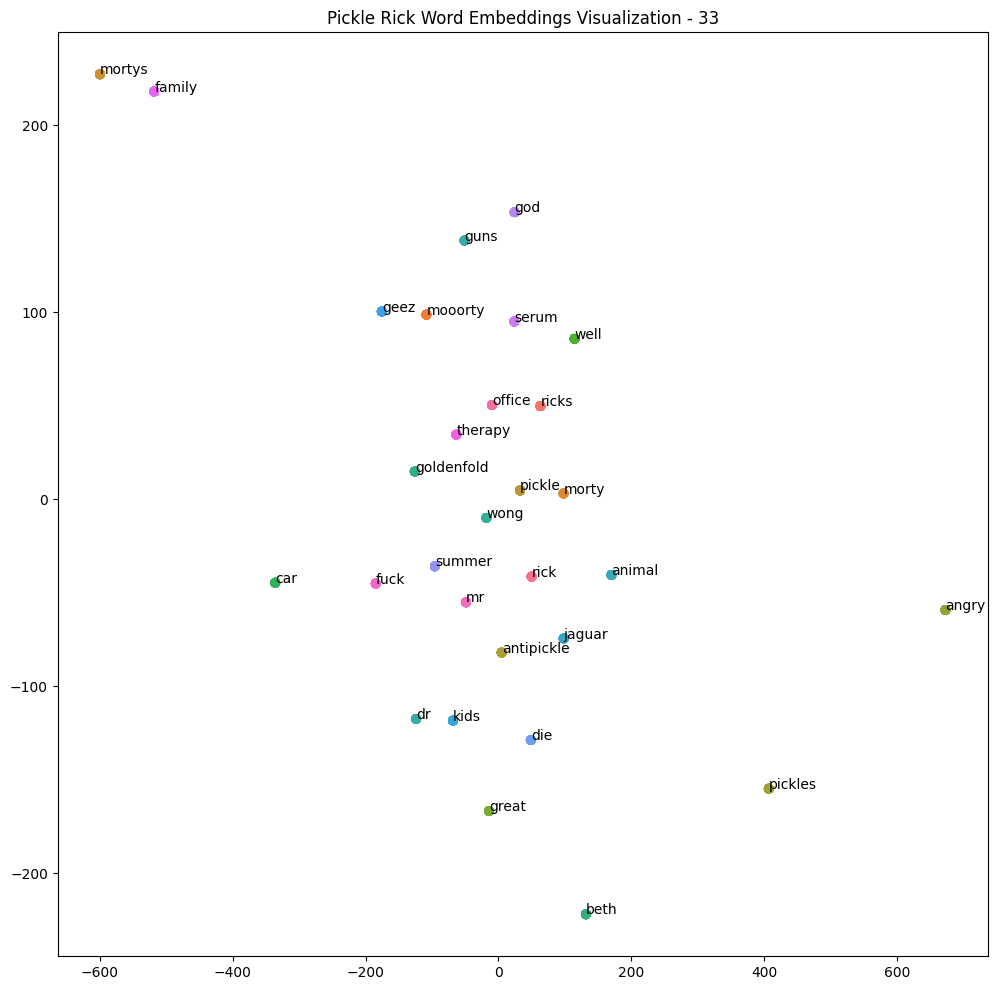

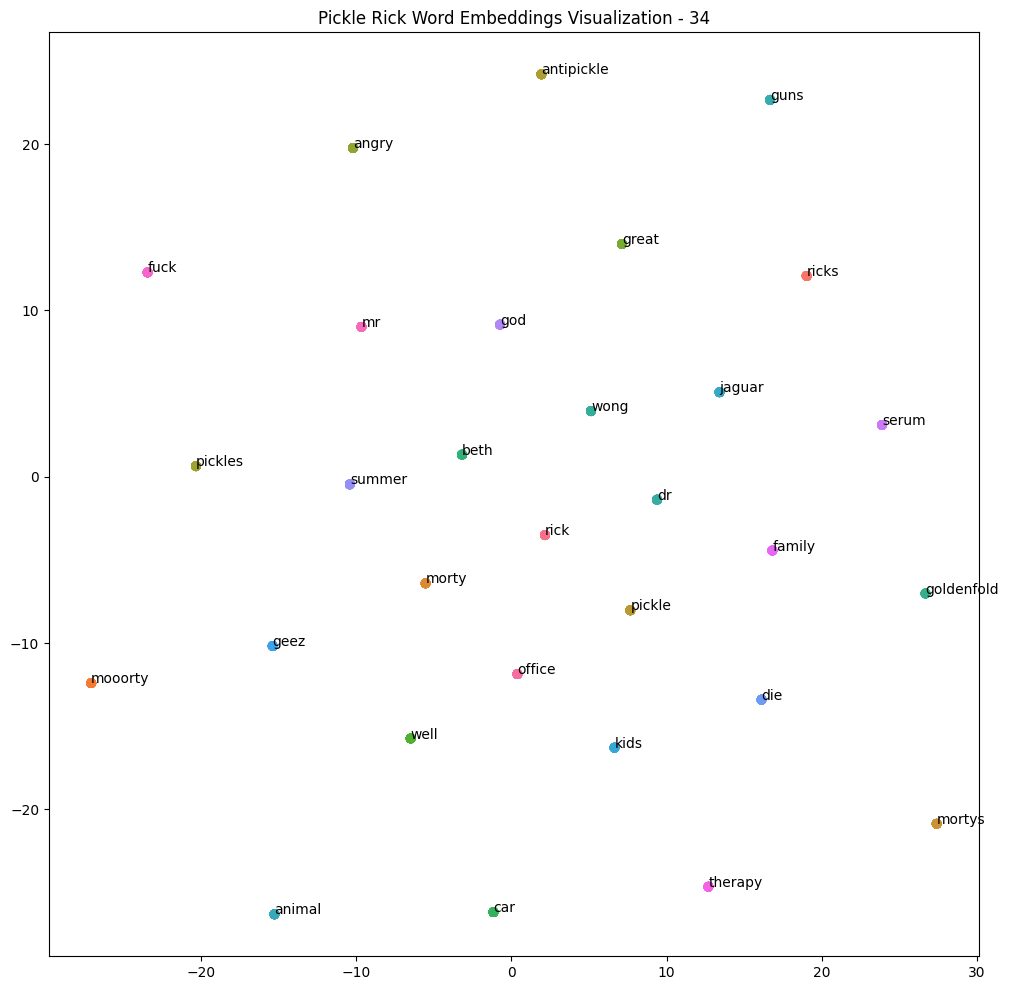

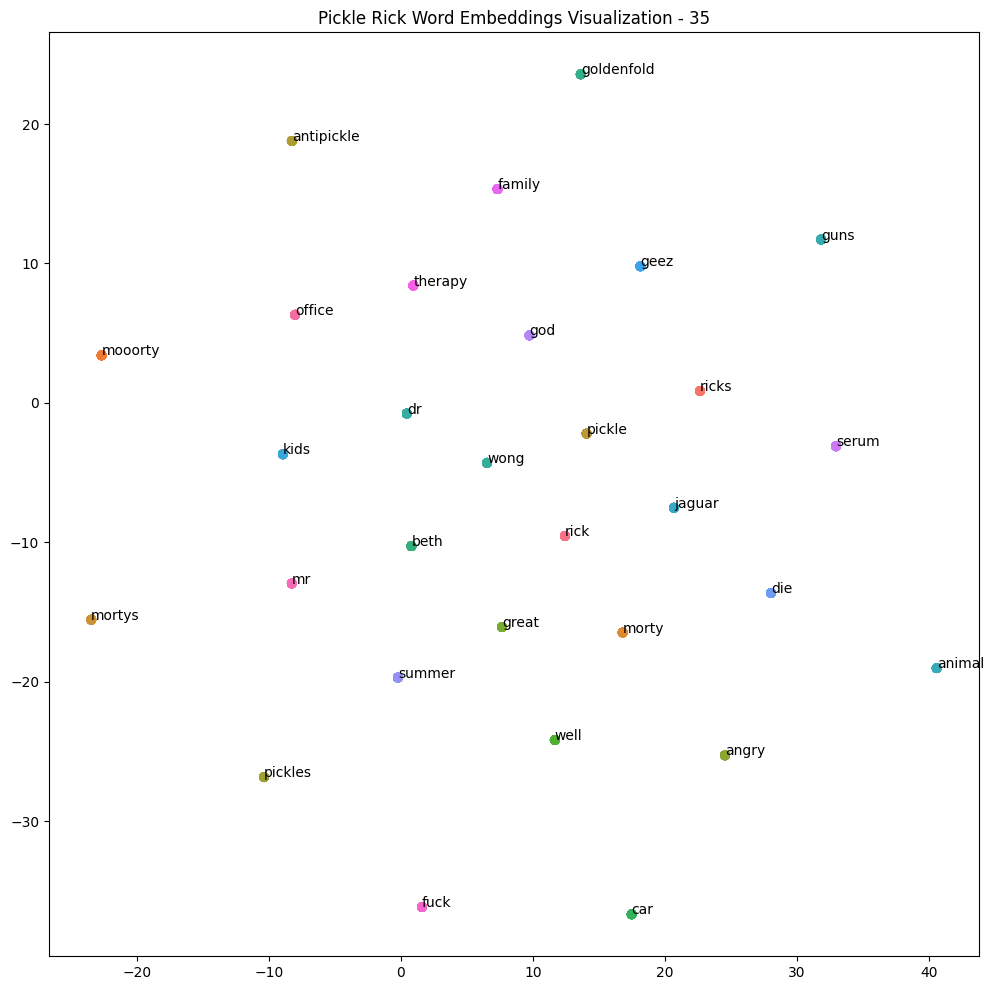

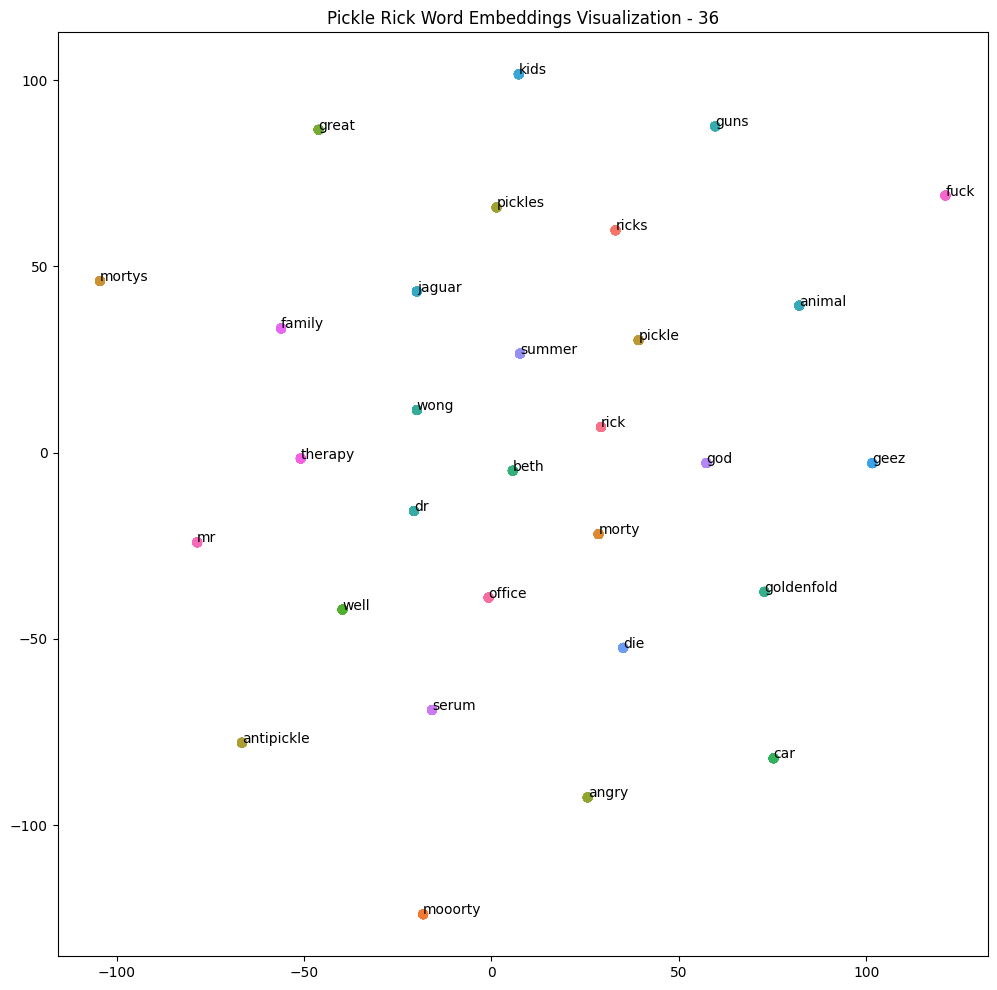

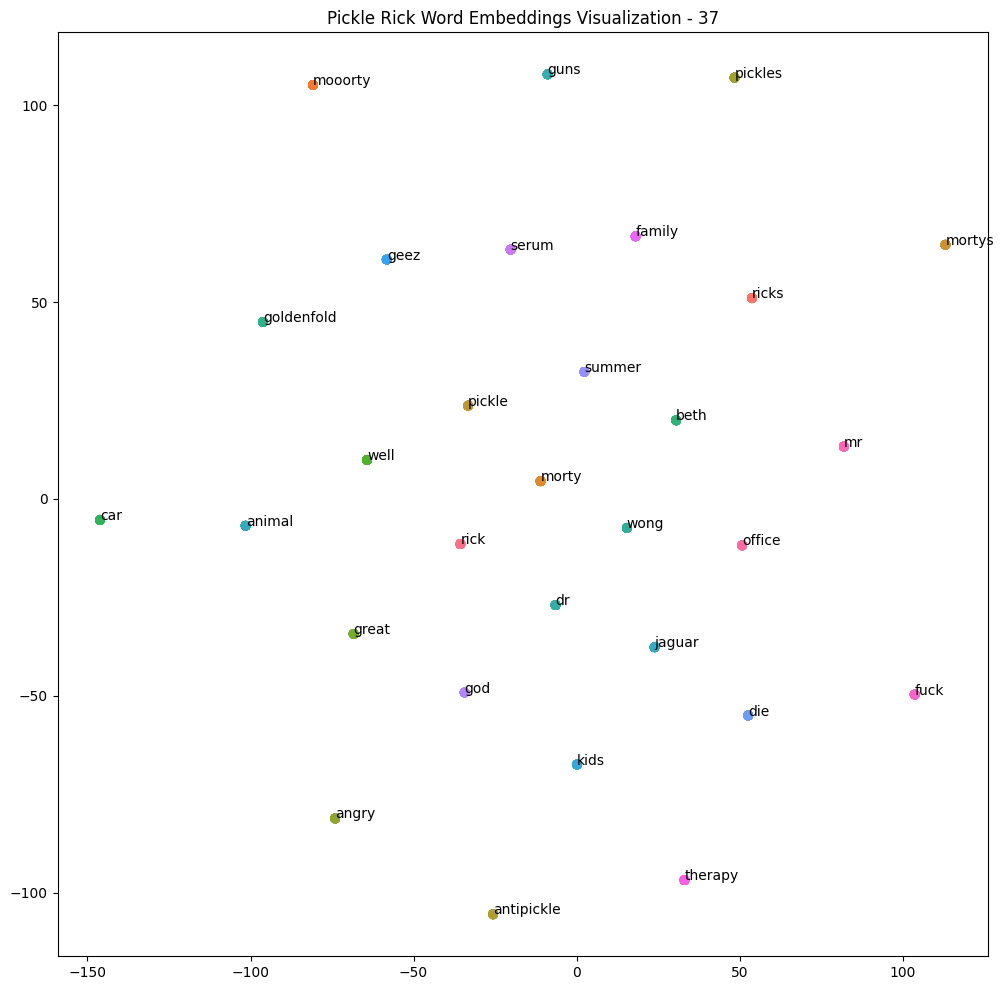

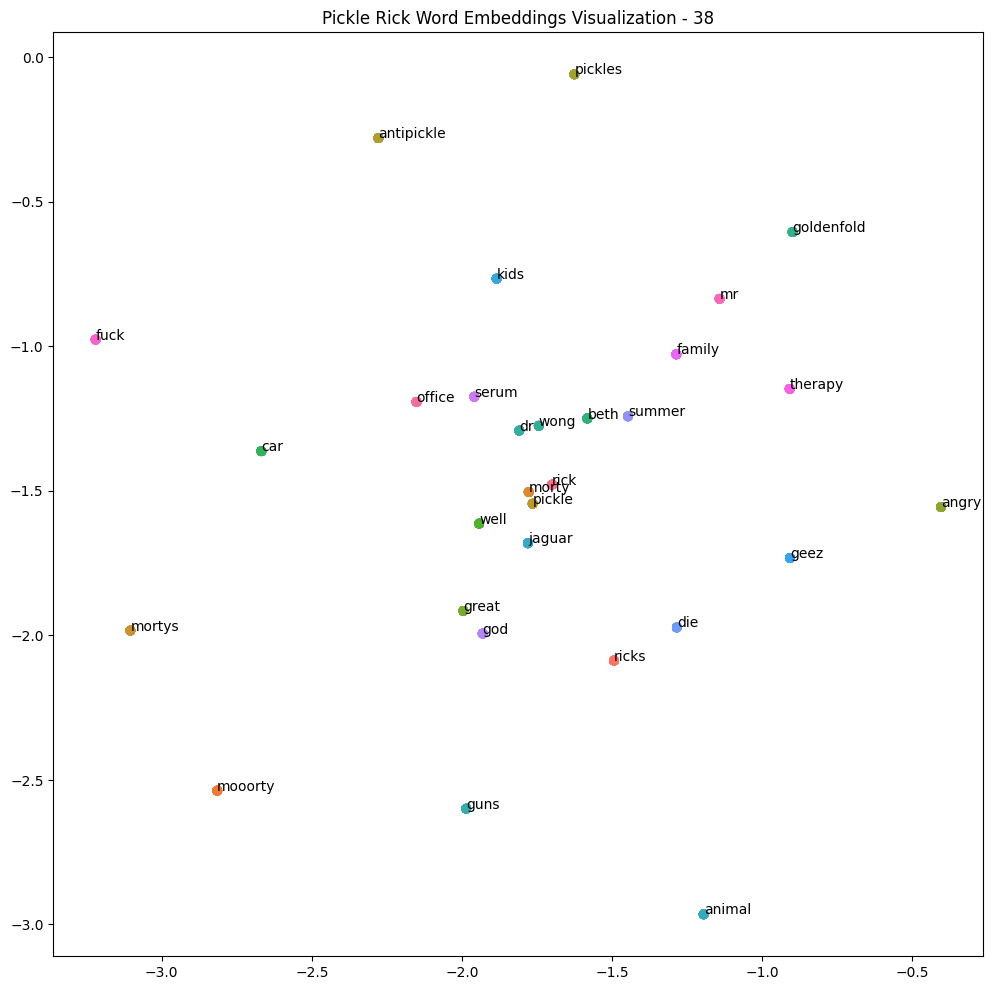

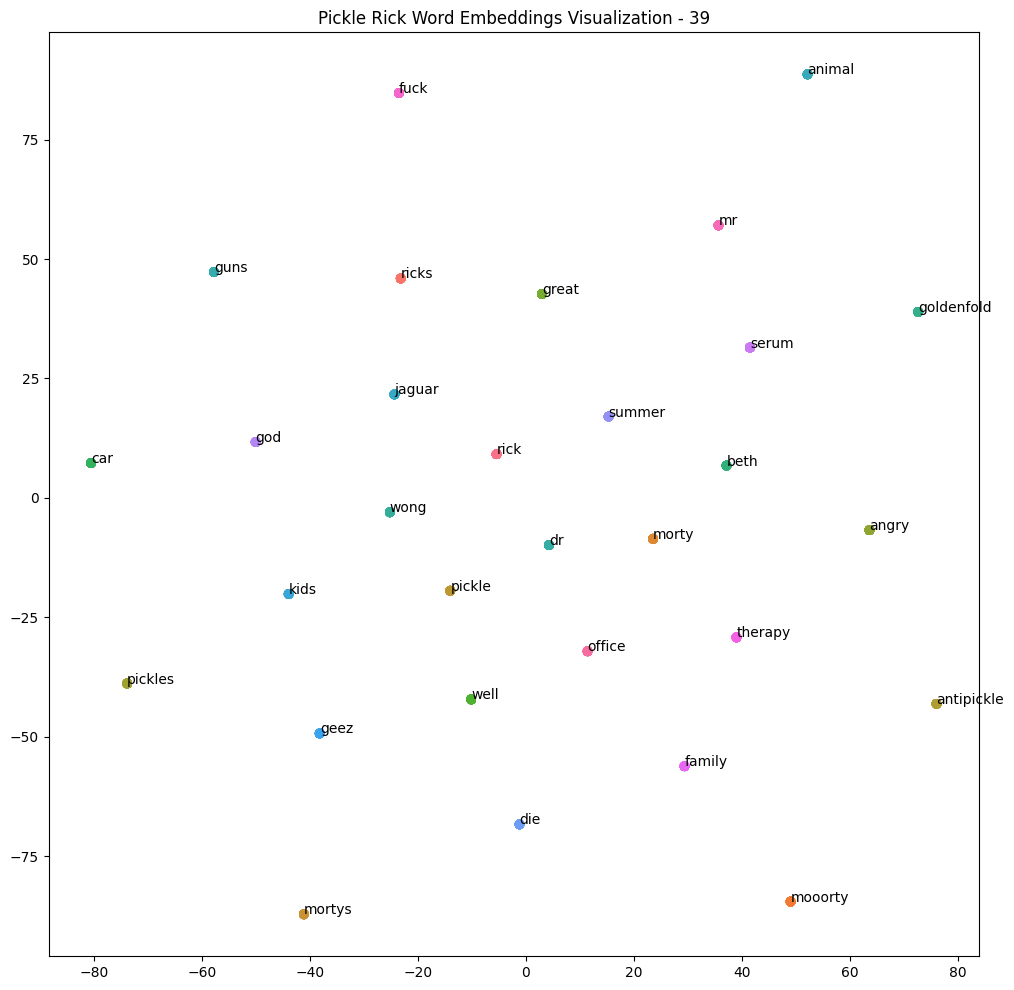

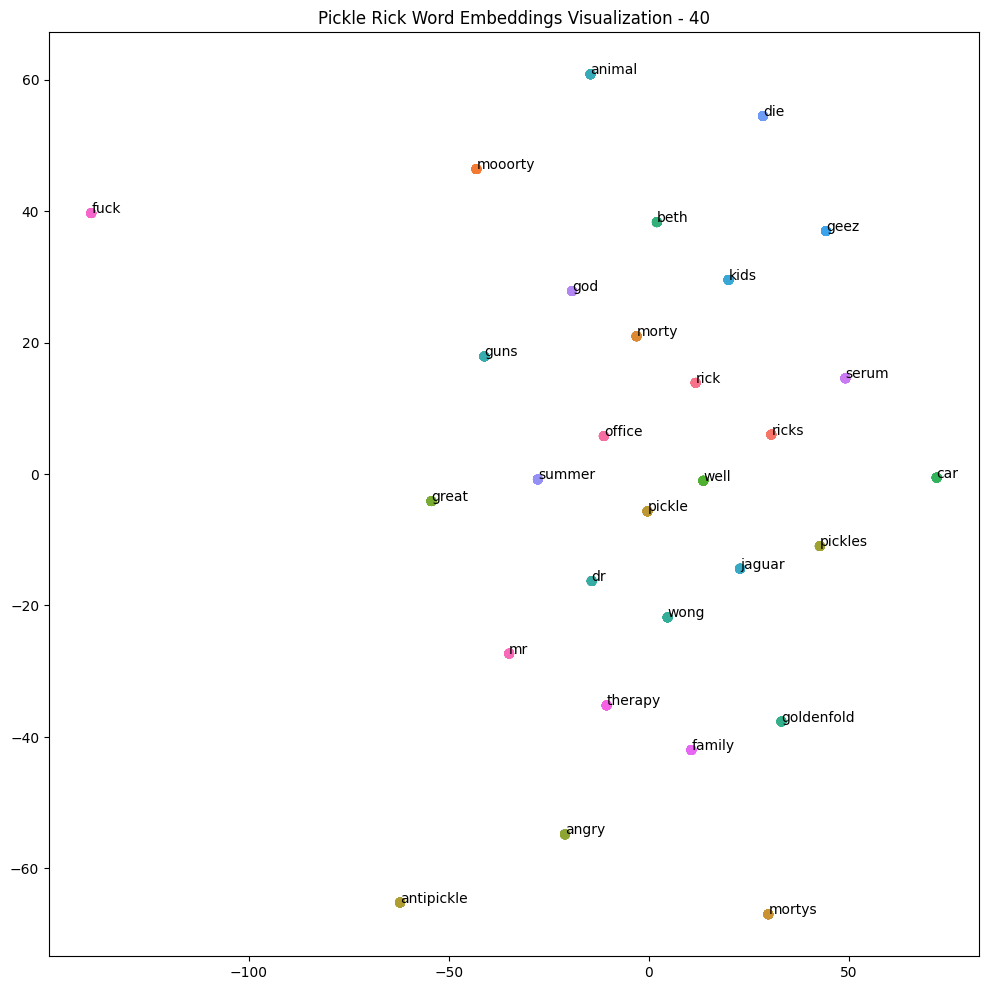

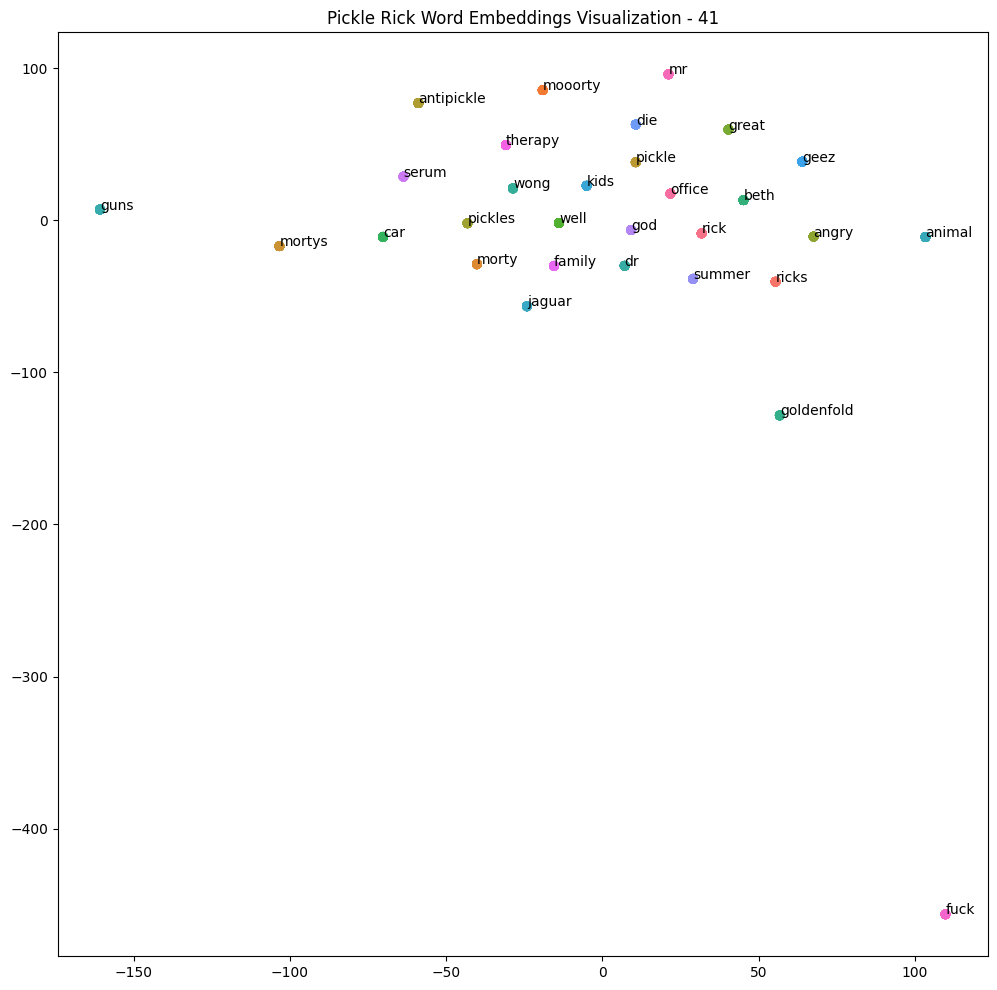

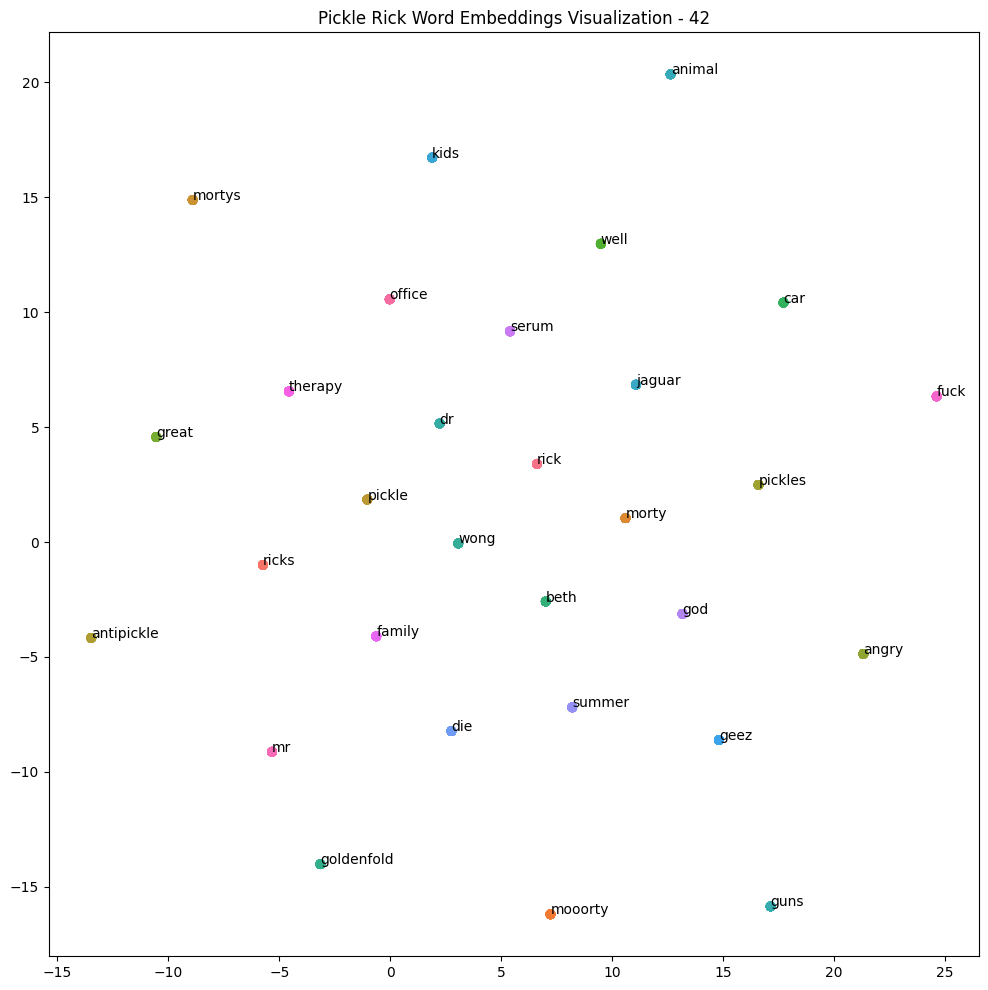

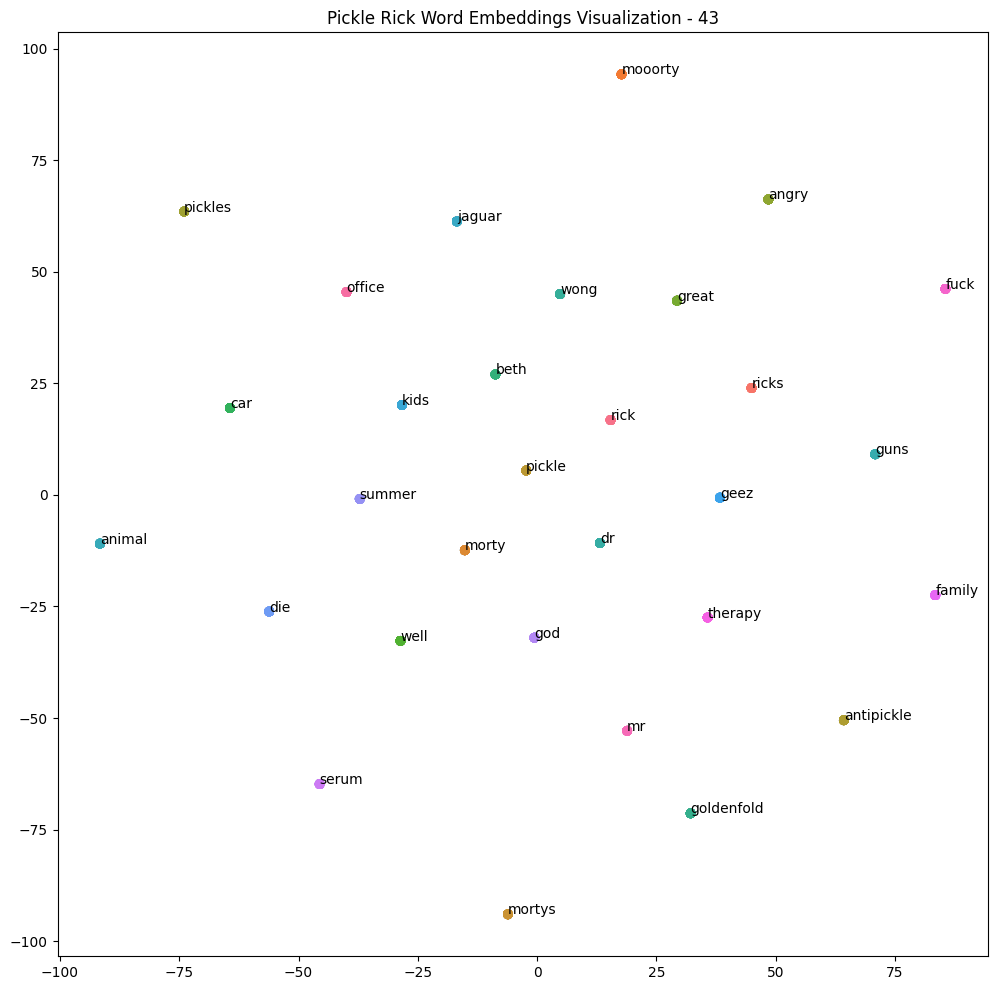

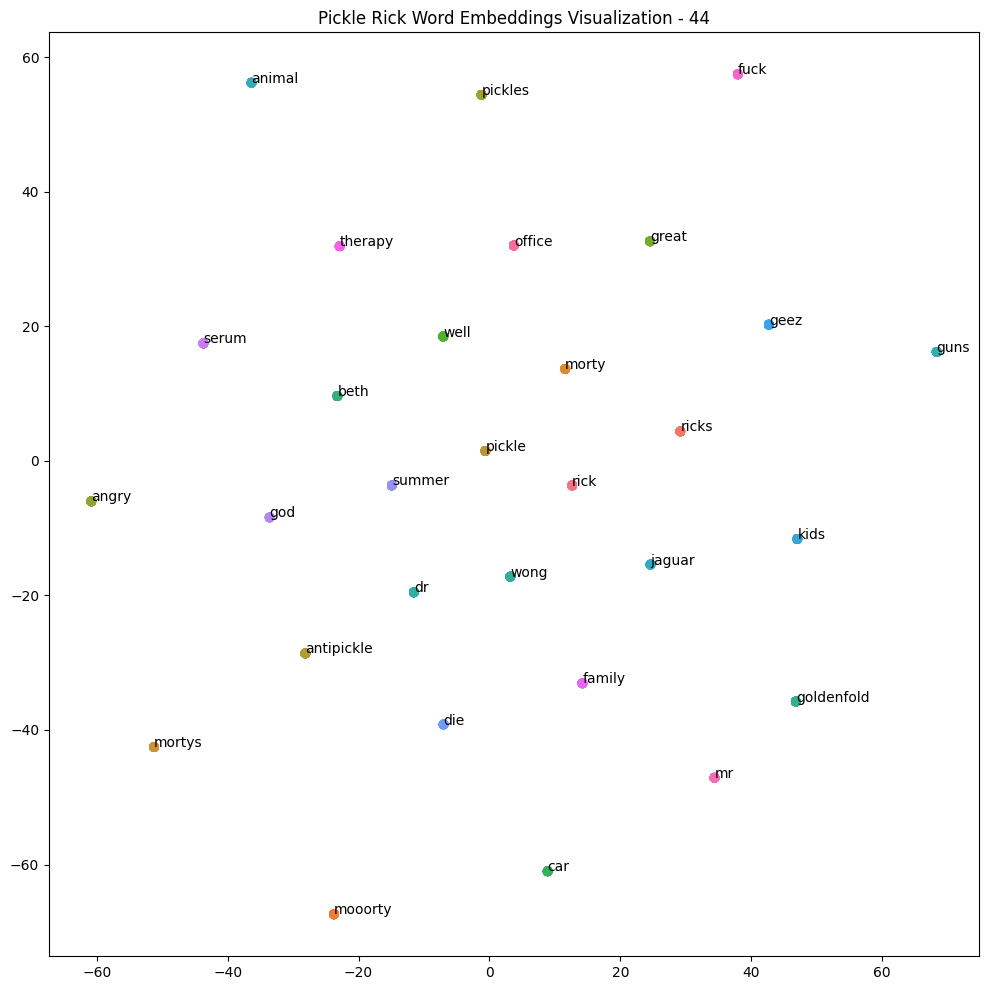

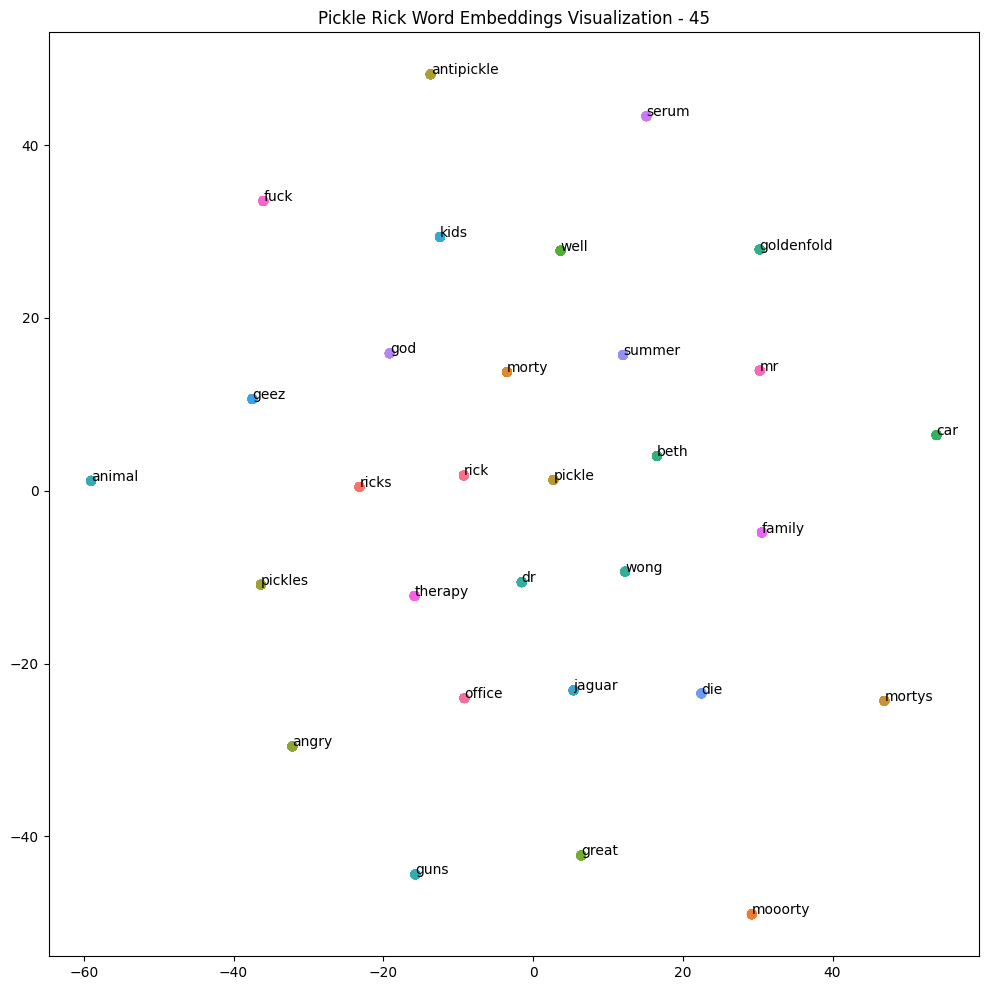

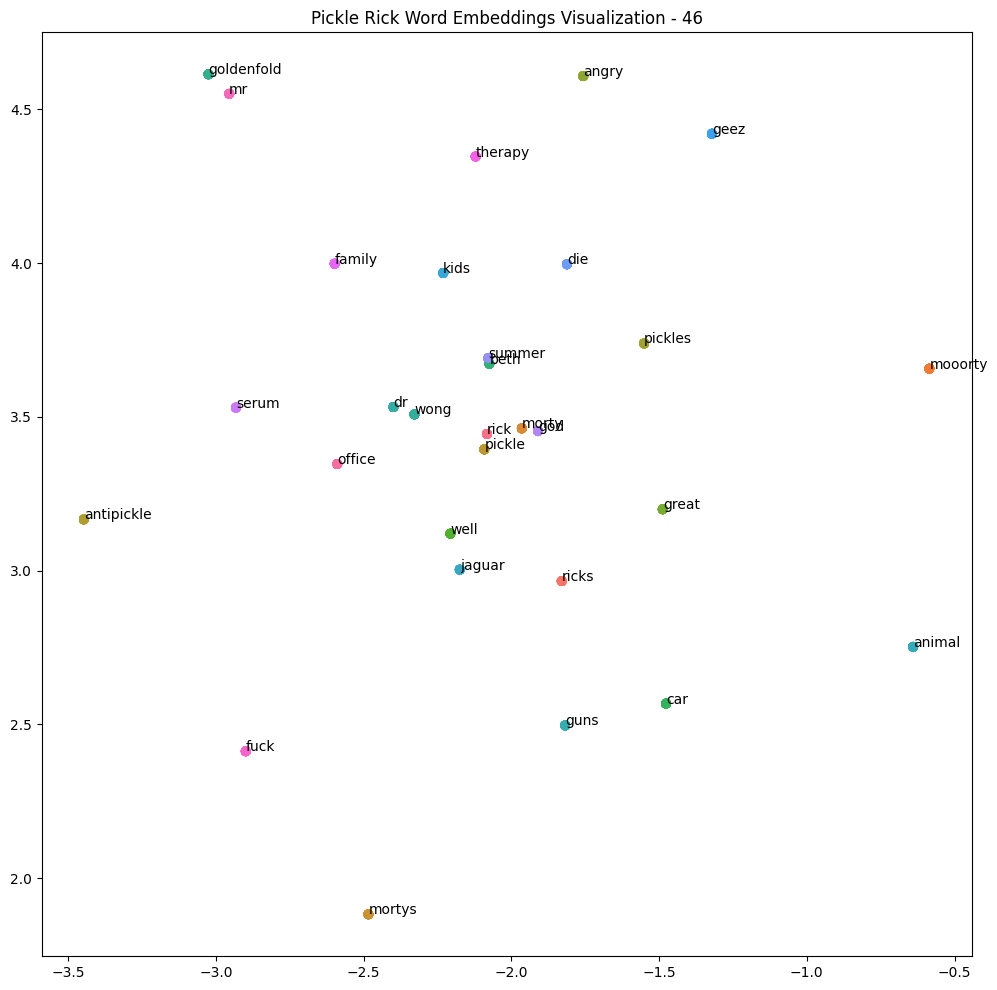

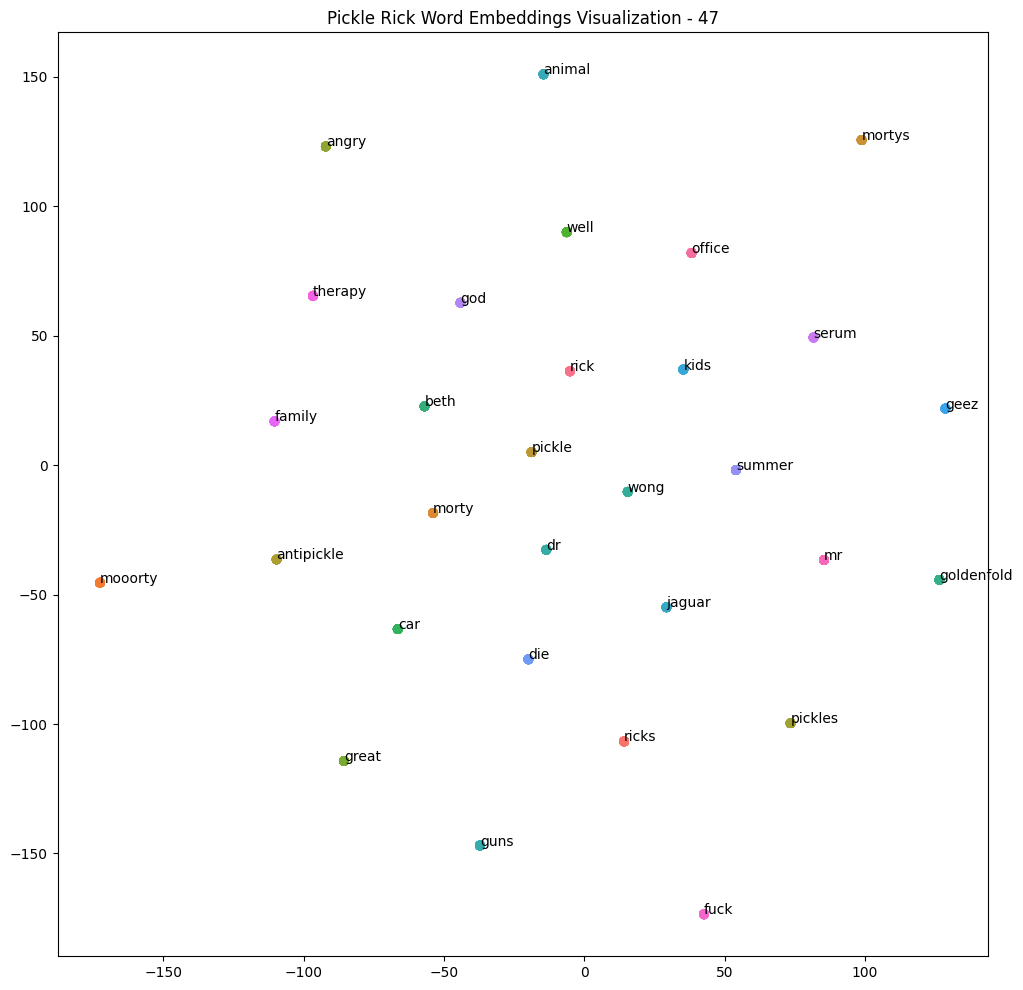

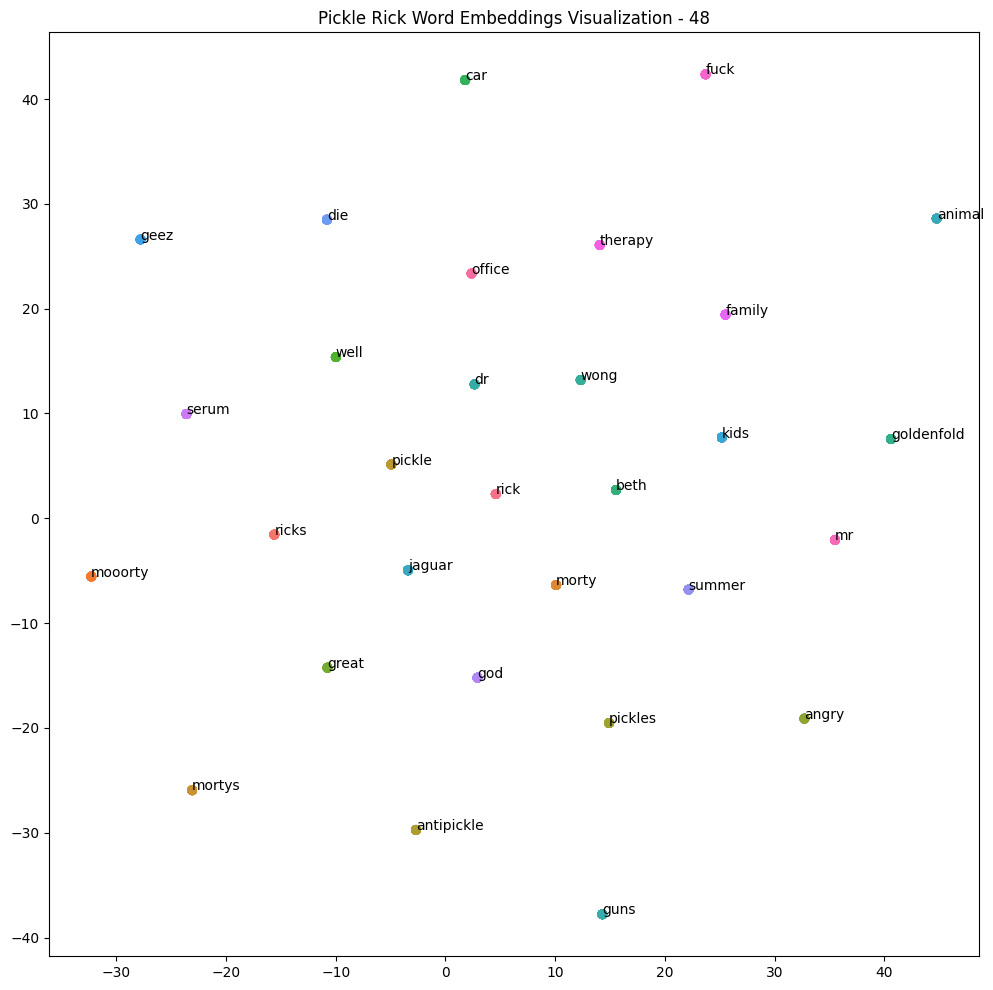

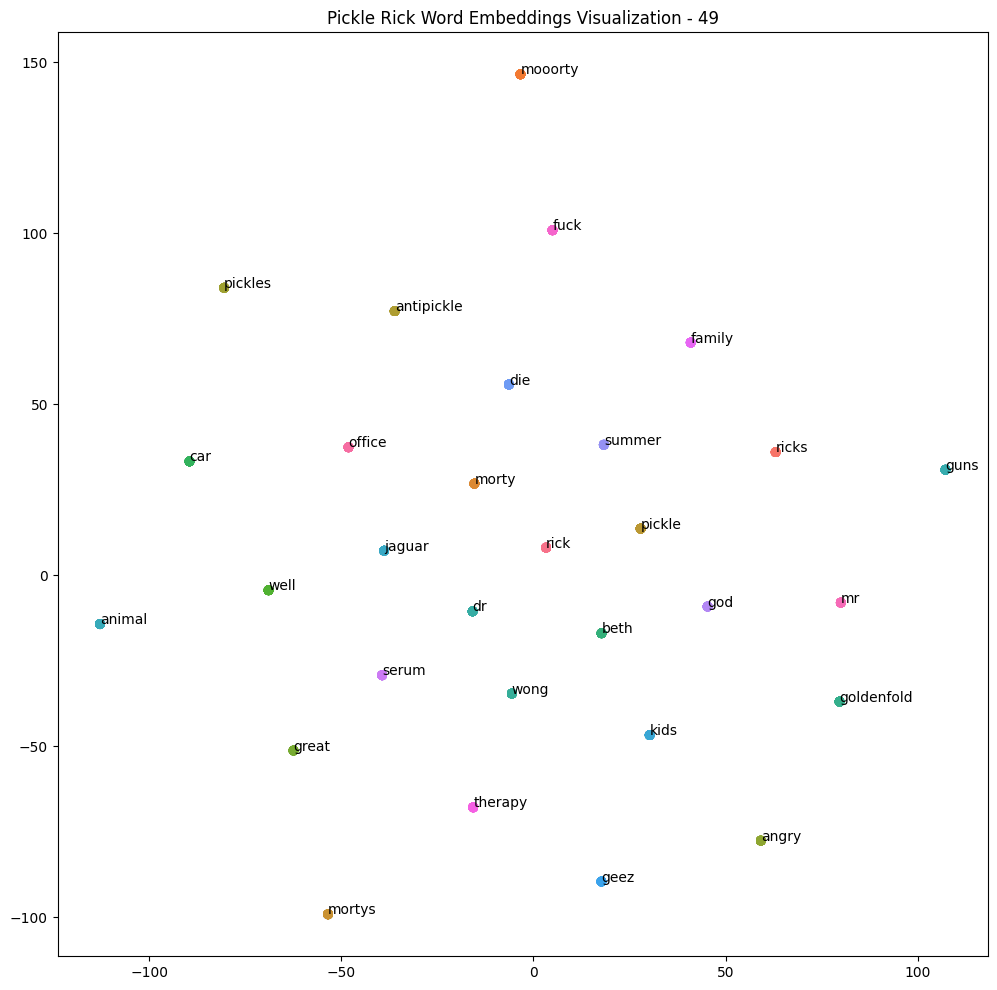

In [ ]:
def visualize_words_embedding(model,epoch_number):
  #sélection d'un petit groupe de mots
  words_to_visualize = ['rick','ricks','mooorty', 'morty', 'mortys','pickle','antipickle','pickles','angry','great','well','car','beth','goldenfold','wong','dr','guns','animal','jaguar','kids','geez','die','summer','god','serum','family','therapy','fuck','mr','office']

  #extraction des poids du modèle
  word_vectors = model.embeddings.weight.data

  #Obtention des word embeddings
  indices = [word2index[word] for word in words_to_visualize]
  word_vectors = model.embeddings.weight.data[indices]

  #fit d'un modèle 2d TSNE aux vecteurs d'embeddings
  tsne = TSNE(n_components=2,perplexity=20)
  word_vectors_2d = tsne.fit_transform(word_vectors)

  #couleur spécifique pour chaque point
  colors = sns.husl_palette(n_colors = len(words_to_visualize))

  #création d'un diagramme de dispersion de la projection
  plt.figure(figsize=(12,12))

  #annotation des points sur le graphe
  for i, word in enumerate(words_to_visualize):
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1],c=colors)
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

  plt.title(f'Pickle Rick Word Embeddings Visualization - {epoch_number}')

  # Save the figure
  plt.savefig(f'word_embeddings_epoch_{epoch_number}.png')

#initialisation
model = SkipGramModel(len(vocab), embedding_size=embedding_size)

#initialisation des fonctions de perte et d'optimisation
loss_function = nn.CrossEntropyLoss() #calcul le taux d'erreur entre la valeur prédite et l'originale
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Descente de Gradient Stochastique

#visualisation des word embeddings avant l'entraînement
visualize_words_embedding(model, "Before Training")

#début de l'entraînement
for epoch in range(epochs):
  total_loss = 0
  #itération sur l'ensemble du batch
  for i in range(0, len(X_train), batch_size):
    x = X_train[i:i+batch_size]
    y_true = y_train[i:i+batch_size]
    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_function(y_pred, y_true.view(-1))
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f'Epoch num : {epoch+1}, Loss value : {total_loss:.3f}')

  visualize_words_embedding(model, epoch)